## Load in libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

## Load in data

In [11]:
training_df = pd.read_csv('/content/loan_train.csv')

training_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501.0,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430.0,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1076863.0,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1069639.0,1304742.0,7000.0,7000.0,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1072053.0,1288686.0,3000.0,3000.0,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29777 entries, 0 to 29776
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29774 non-null  float64
 1   member_id                   29774 non-null  float64
 2   loan_amnt                   29774 non-null  float64
 3   funded_amnt                 29774 non-null  float64
 4   funded_amnt_inv             29774 non-null  float64
 5   term                        29774 non-null  object 
 6   int_rate                    29774 non-null  object 
 7   installment                 29774 non-null  float64
 8   grade                       29774 non-null  object 
 9   sub_grade                   29774 non-null  object 
 10  emp_title                   27955 non-null  object 
 11  emp_length                  29015 non-null  object 
 12  home_ownership              29774 non-null  object 
 13  annual_inc                  297

## Clean the columns -- it's no fun dealing with messy data

In [ ]:
training_df.columns = ( training_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '')
    .str.replace('$', '')
    .str.replace('""', '')
    .str.replace('!', '')
)

## DateTime Cleaning

In [ ]:
training_df['issue_d'] = pd.to_datetime(training_df['issue_d']) # change issue date to a datetime
training_df['earliest_cr_line'] = pd.to_datetime(training_df['earliest_cr_line']) # change earliest credit line to a datetime
training_df['last_pymnt_d'] = pd.to_datetime(training_df['last_pymnt_d']) # change earliest credit line to a datetime
training_df['last_credit_pull_d'] = pd.to_datetime(training_df['last_credit_pull_d']) # change earliest credit line to a datetime

<ipython-input-21-faa47054ffa9>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  training_df['issue_d'] = pd.to_datetime(training_df['issue_d']) # change issue date to a datetime
<ipython-input-21-faa47054ffa9>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  training_df['earliest_cr_line'] = pd.to_datetime(training_df['earliest_cr_line']) # change earliest credit line to a datetime
<ipython-input-21-faa47054ffa9>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  training_df['last_pymnt_d'] = pd.to_datetime(training_df['last_pymnt_d']) # change earliest credit line to a date

## Change emp_length and term to integers

In [ ]:
training_df["emp_length"].value_counts() # change employment length from an object to numerical

emp_length
10+ years    6577
< 1 year     3491
2 years      3313
3 years      3008
4 years      2563
1 year       2537
5 years      2441
6 years      1681
7 years      1305
8 years      1126
9 years       973
Name: count, dtype: int64

In [ ]:
numeric_mapping_emp_length = {
    '10+ years': 10,
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9
}


training_df['emp_length'] = training_df['emp_length'].map(numeric_mapping_emp_length)

In [ ]:
training_df["term"].value_counts() # change employment length from an object to numerical

term
36 months    22160
60 months     7614
Name: count, dtype: int64

In [ ]:
numeric_mapping_term_length = {
    '26 months': 36,
    '60 months': 60
}


training_df["term"] = training_df["term"].map(numeric_mapping_term_length)

## Change interest rate to float

In [ ]:
training_df['int_rate'] = training_df['int_rate'].str.replace('%', '')
training_df['int_rate'] = training_df['int_rate'].astype(float)
training_df['int_rate'] = training_df['int_rate'] / 100
training_df.head(n=3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501.0,1296599.0,5000.0,5000.0,4975.0,NaN,0.1065,162.87,B,B2,...,NaN,2016-09-01,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430.0,1314167.0,2500.0,2500.0,2500.0,60.0,0.1527,59.83,C,C4,...,NaN,2016-09-01,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1076863.0,1277178.0,10000.0,10000.0,10000.0,NaN,0.1349,339.31,C,C1,...,NaN,2016-04-01,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [ ]:
training_df['revol_util'] = training_df['revol_util'].str.replace('%', '')
training_df['revol_util'] = training_df['revol_util'].astype(float)
training_df['revol_util'] = training_df['revol_util'] / 100
training_df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501.0,1296599.0,5000.0,5000.0,4975.0,NaN,0.1065,162.87,B,B2,...,NaN,2016-09-01,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430.0,1314167.0,2500.0,2500.0,2500.0,60.0,0.1527,59.83,C,C4,...,NaN,2016-09-01,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1076863.0,1277178.0,10000.0,10000.0,10000.0,NaN,0.1349,339.31,C,C1,...,NaN,2016-04-01,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1069639.0,1304742.0,7000.0,7000.0,7000.0,60.0,0.1596,170.08,C,C5,...,NaN,2016-09-01,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1072053.0,1288686.0,3000.0,3000.0,3000.0,NaN,0.1864,109.43,E,E1,...,NaN,2014-12-01,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29772,72998.0,72992.0,1000.0,1000.0,0.0,NaN,0.0964,32.11,B,B4,...,Jul-2010,2014-09-01,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
29773,72176.0,70868.0,2525.0,2525.0,225.0,NaN,0.0933,80.69,B,B3,...,Jul-2010,2007-05-01,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
29774,71623.0,70735.0,6500.0,6500.0,0.0,NaN,0.0838,204.84,A,A5,...,Jul-2010,2007-08-01,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
29775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## How many loans default in the dataset?

In [ ]:
training_df['loan_status'].value_counts(normalize = True)

loan_status
current    0.849649
default    0.150351
Name: proportion, dtype: float64

## Since ~15% of the dataset has defaulted loans, we do not need to perform upsampling or SMOTE

## The default accuracy is 84.96%; if we classified every transaction as legit, we would be correct 84.96% of the time. This will be our benchmark.

## Count Null values

In [ ]:
training_df.isna().sum()

id                                3
member_id                         3
loan_amnt                         3
funded_amnt                       3
funded_amnt_inv                   3
term                          22163
int_rate                          3
installment                       3
grade                             3
sub_grade                         3
emp_title                      1822
emp_length                      762
home_ownership                    3
annual_inc                        4
verification_status               3
issue_d                           3
loan_status                       0
pymnt_plan                        3
url                               3
desc                           9435
purpose                           3
title                            14
zip_code                          3
addr_state                        3
dti                               3
delinq_2yrs                      23
earliest_cr_line                 23
fico_range_low              

## Let's look at the columns!

In [12]:
df = training_df

In [13]:
def df_profile(df, target):

    df = df.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]

    categorical_features = [ c for c in df.select_dtypes(include = "object").columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)
    # -- part 2
    df_stats['feature_type'] = "UNKNOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    # df_stats.loc[df_stats["dtype"] == "float64", 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"] == target, 'feature_type'] = "TARGET"


    # -- part 3
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats["nunique_pct"] > 0.7,'feature_warning' ] = "EXCLUDE, GT 70% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

df_profile(df, "loan_status")

TypeError: can only concatenate str (not "int") to str

## Define numerical and categorical columns of interest

In [ ]:
# Identify categorical and numerical columns
categorical_cols = ["grade", "addr_state", "home_ownership", "verification_status", "pymnt_plan", "purpose",
                    "sub_grade", "application_type"]

numerical_cols = ["fico_range_low", "fico_range_high", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "pub_rec_bankruptcies",
                  "total_acc", "out_prncp_inv", "total_rec_late_fee", "collections_12_mths_ex_med", "policy_code", "out_prncp",
                  "dti", "tax_liens", "loan_amnt", "funded_amnt", "funded_amnt_inv", "annual_inc", "installment", "emp_length", "int_rate",
                  "revol_util", "acc_now_delinq", "chargeoff_within_12_mths", "delinq_2yrs", ]

feature_names = categorical_cols + numerical_cols
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define the target variable
y = training_df['loan_status'].map({'current': 0, 'default': 1})  # Convert to binary
X = training_df.drop('loan_status', axis=1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=223)

## Perform EDA

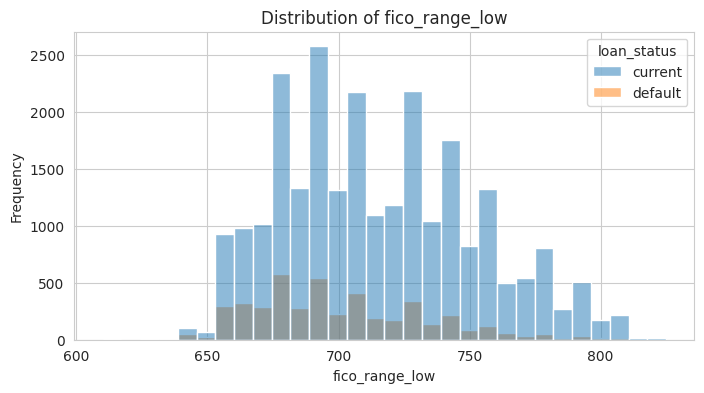

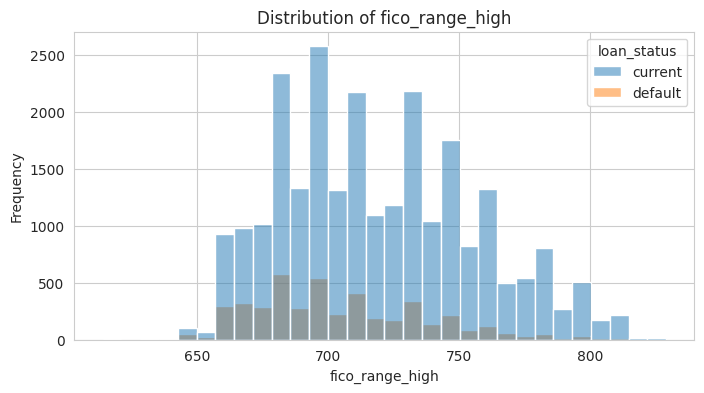

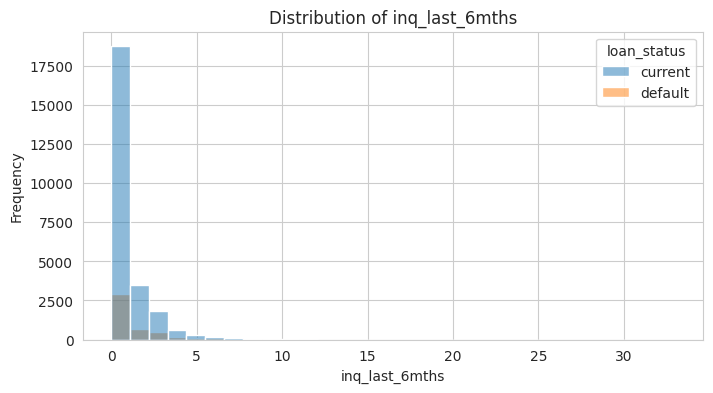

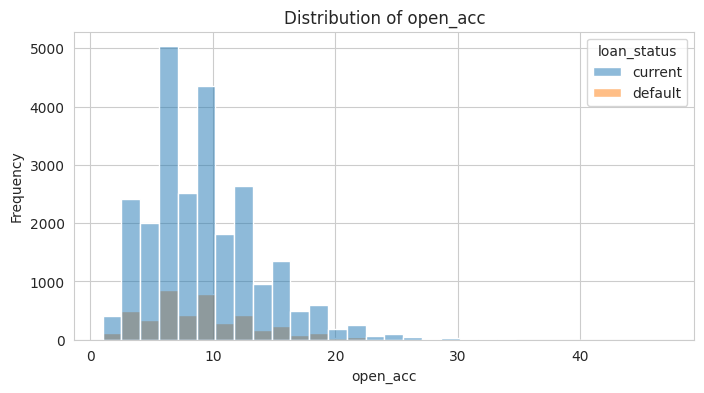

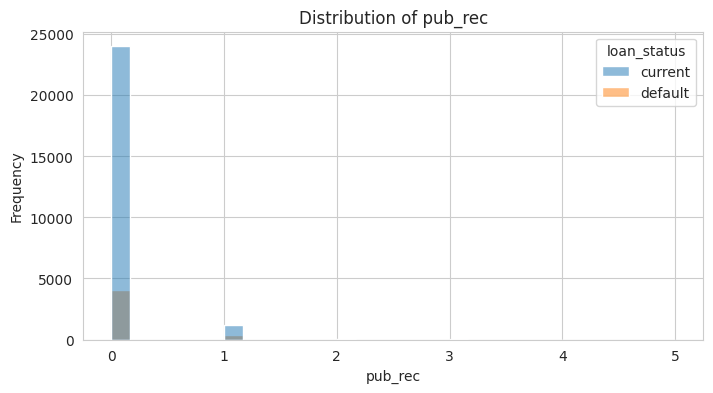

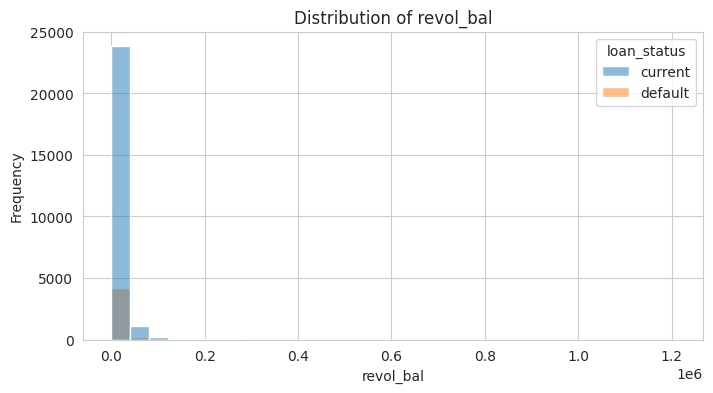

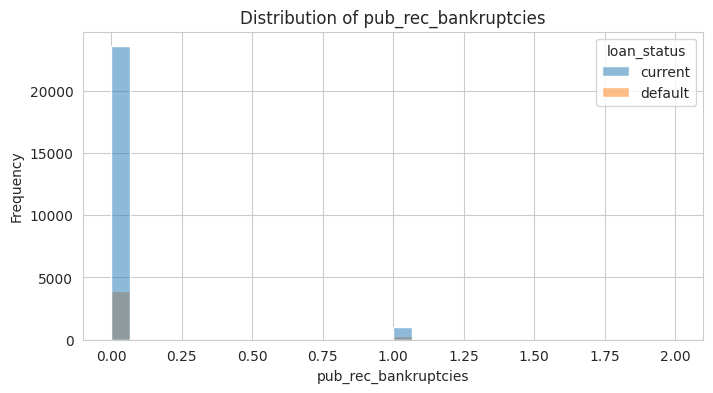

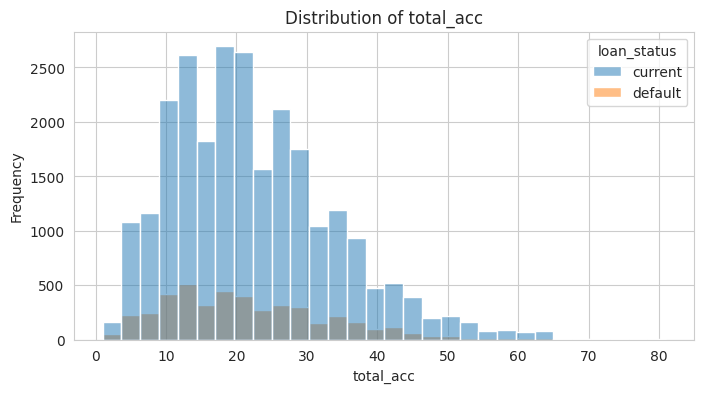

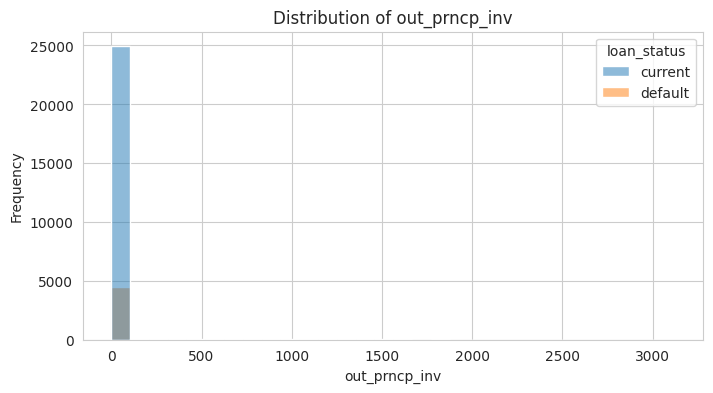

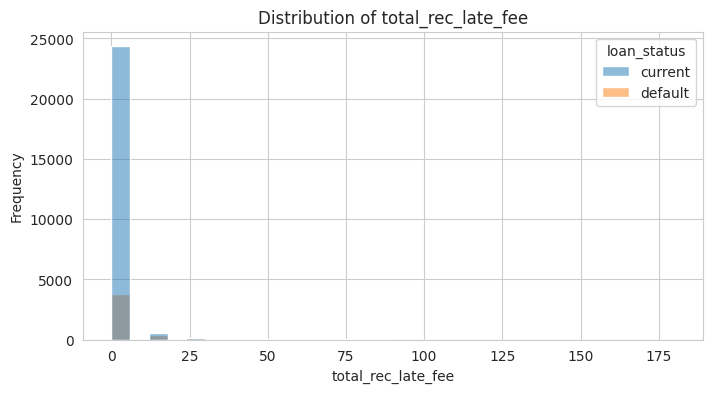

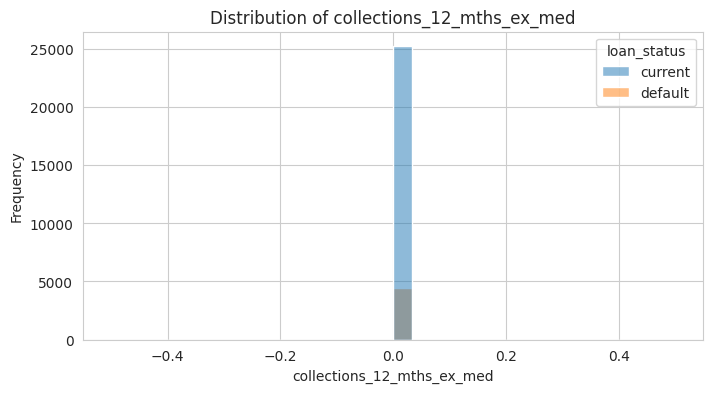

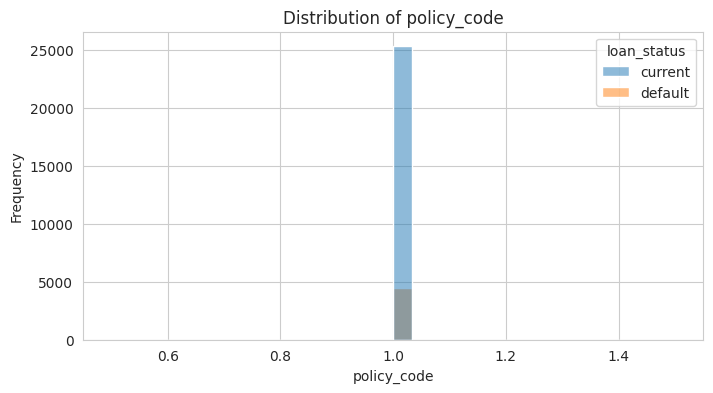

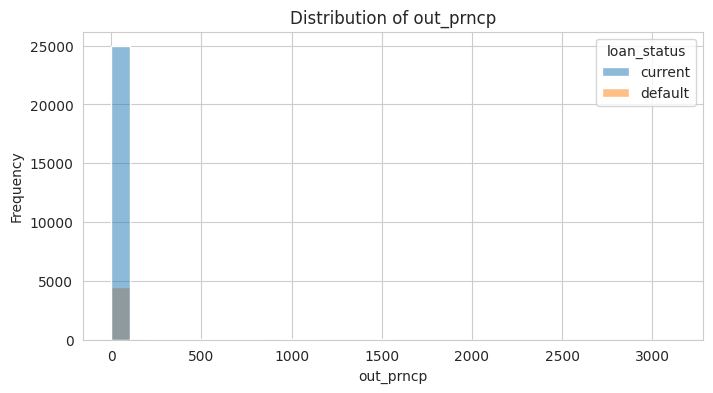

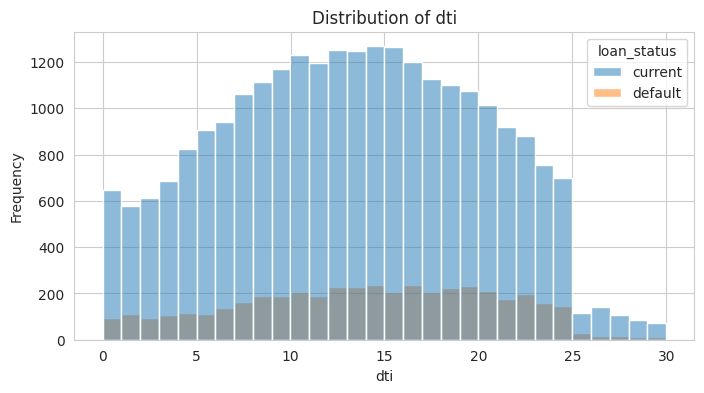

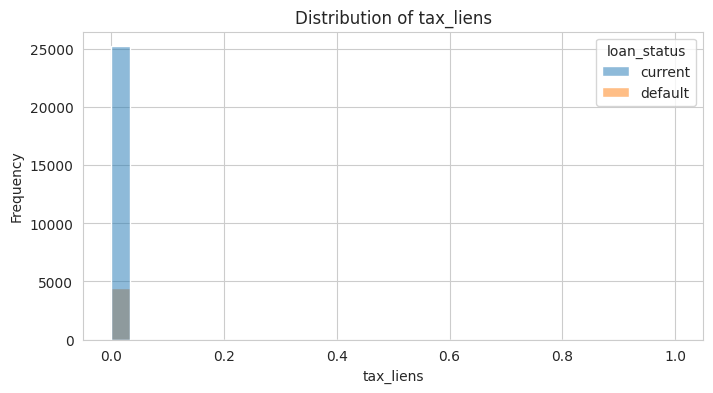

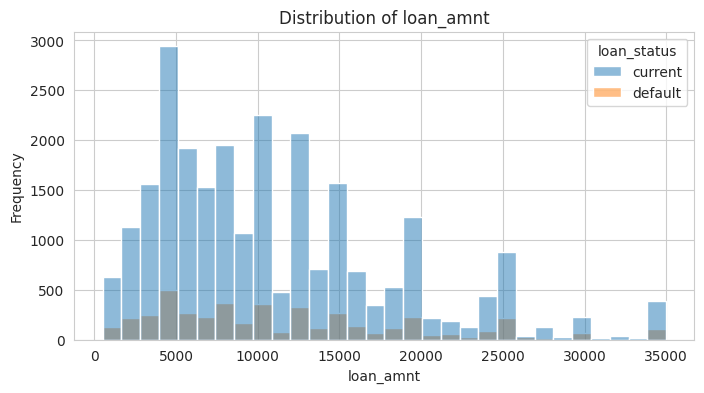

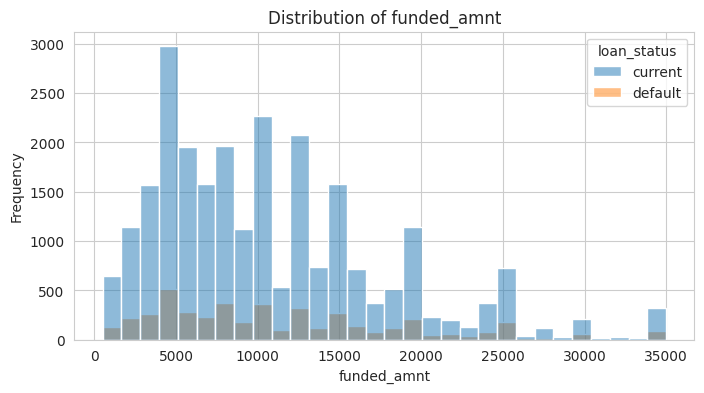

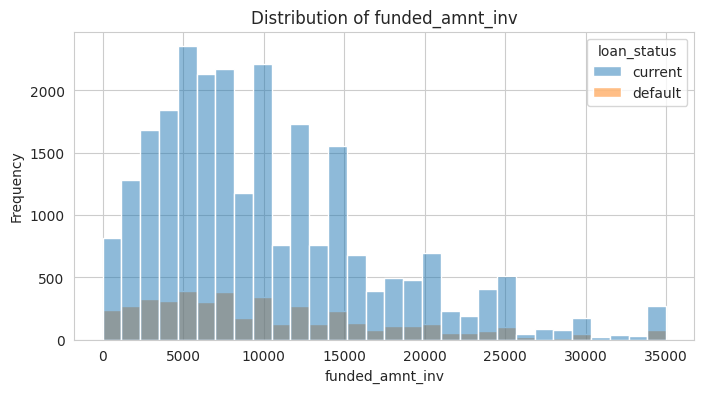

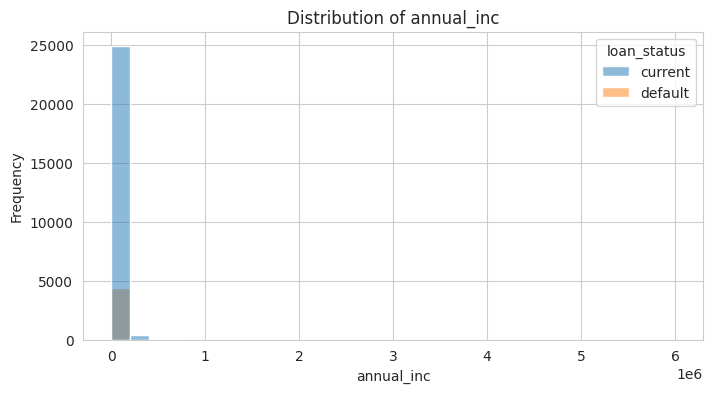

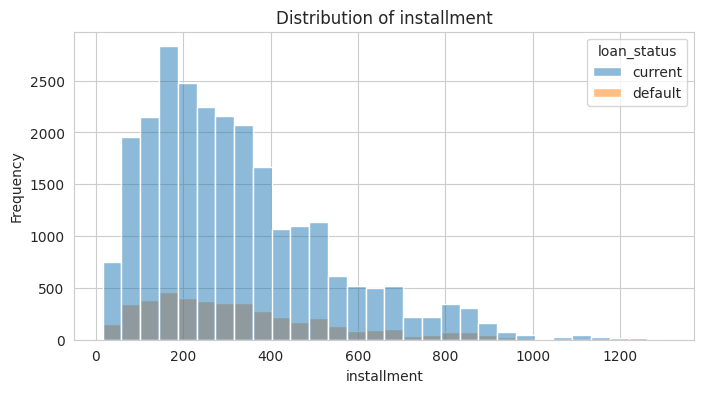

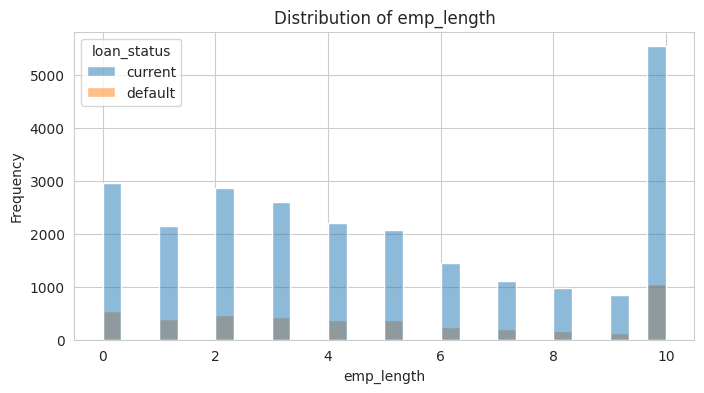

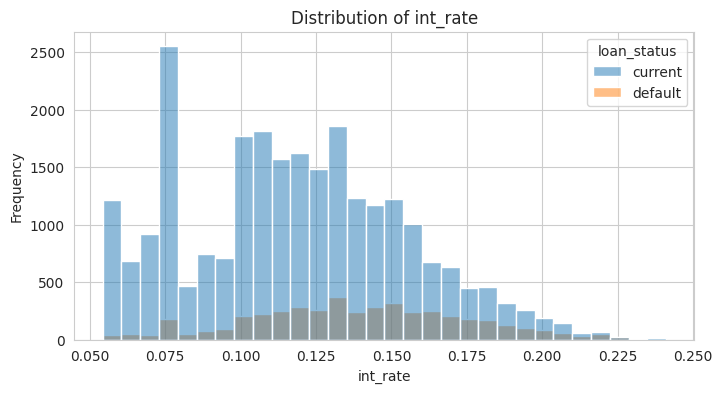

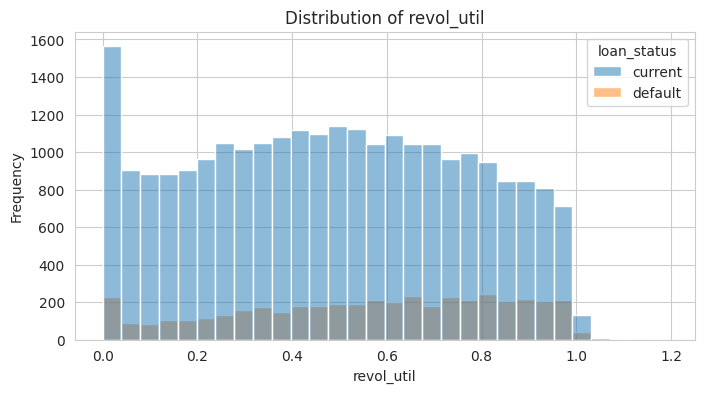

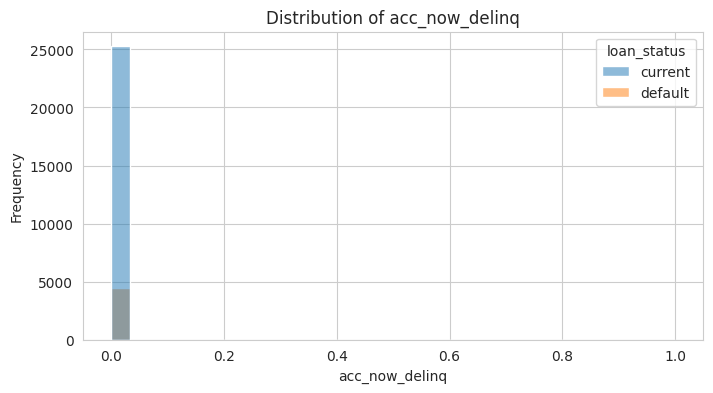

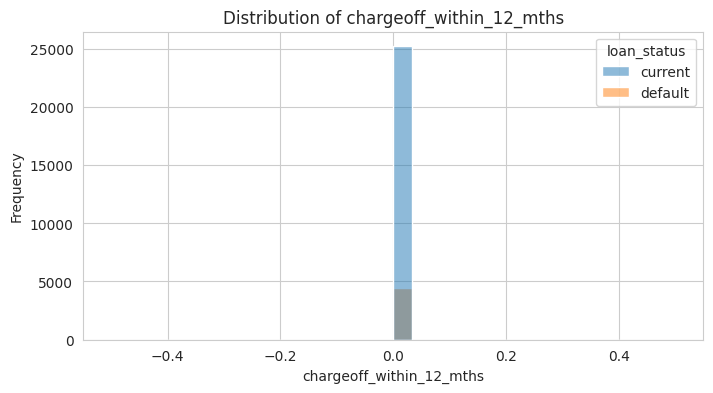

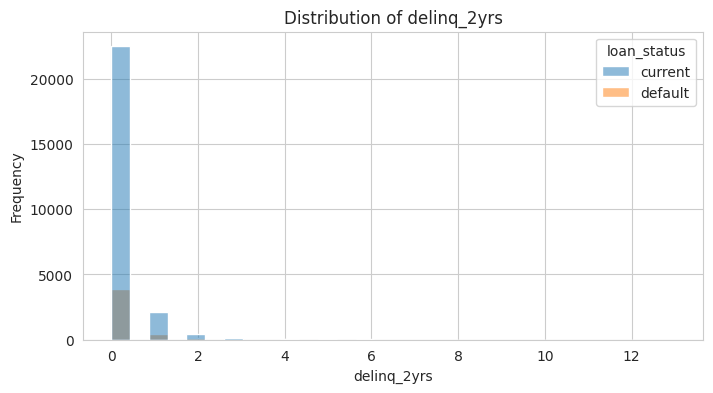

In [ ]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data= training_df, x=col, hue="loan_status", bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

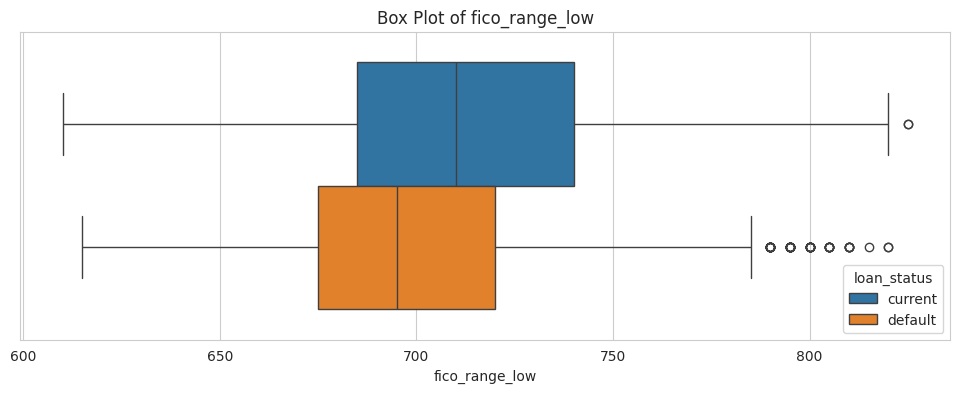

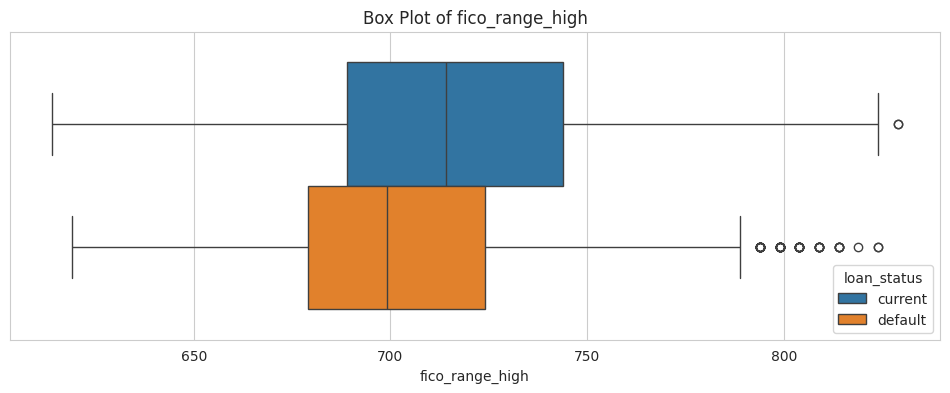

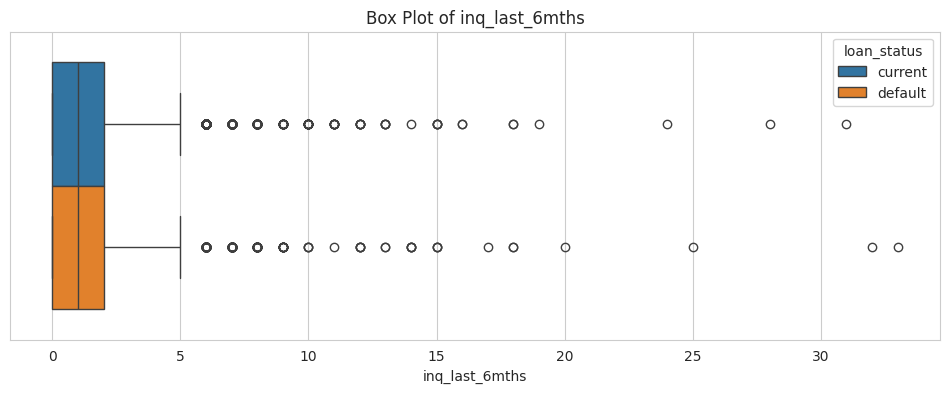

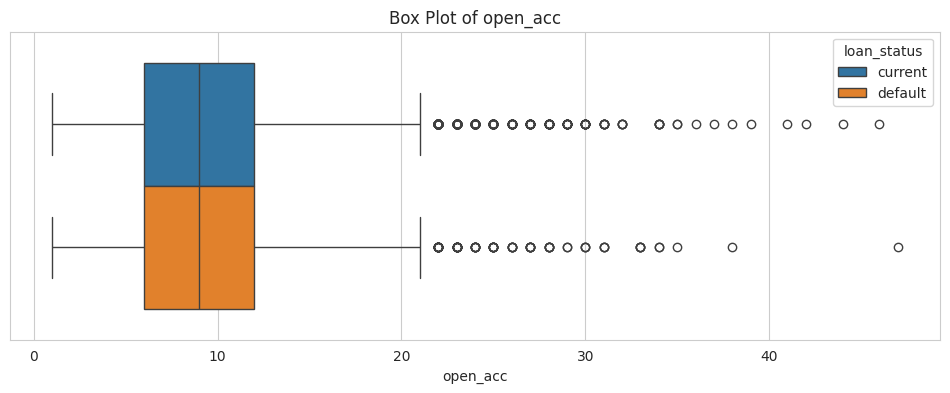

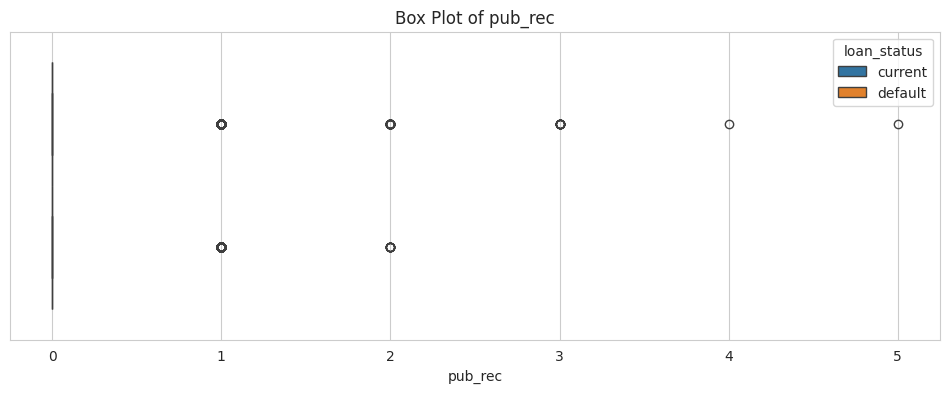

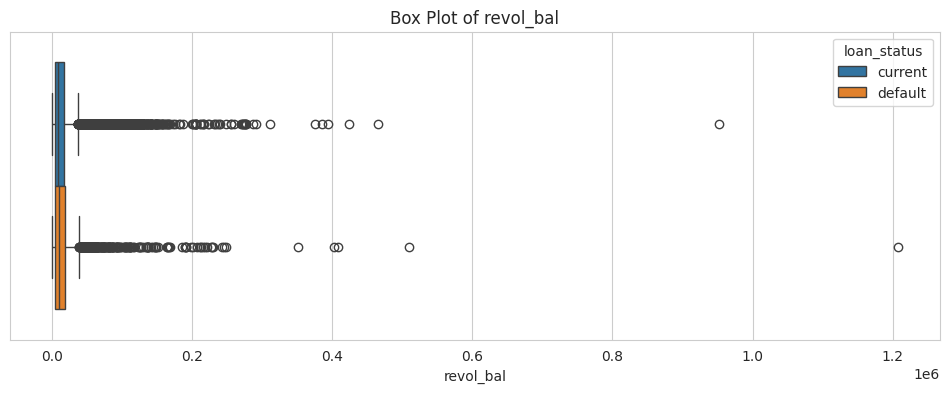

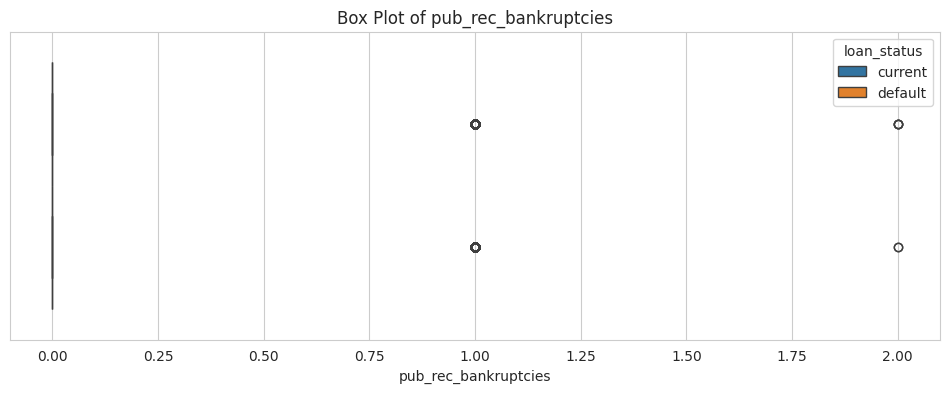

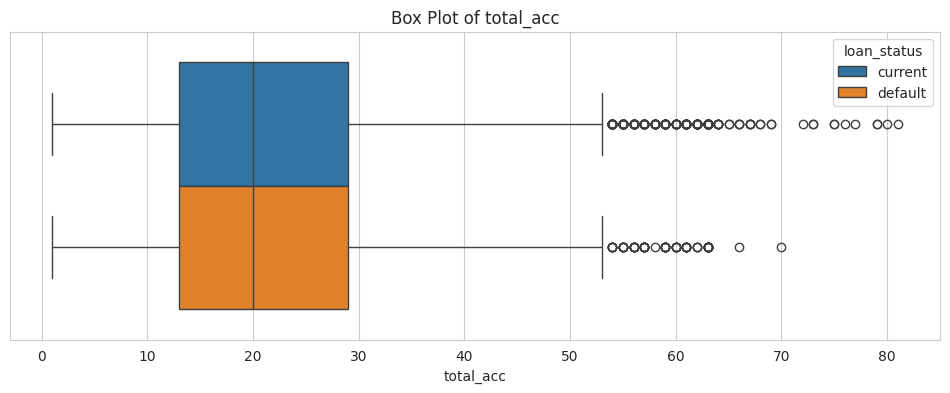

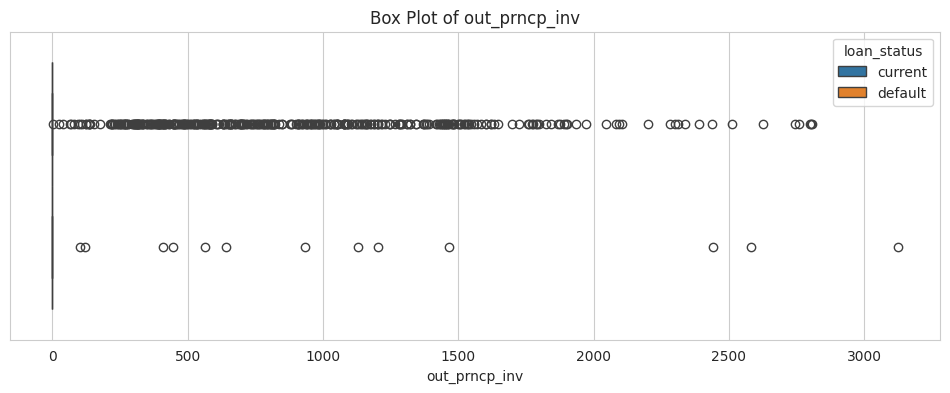

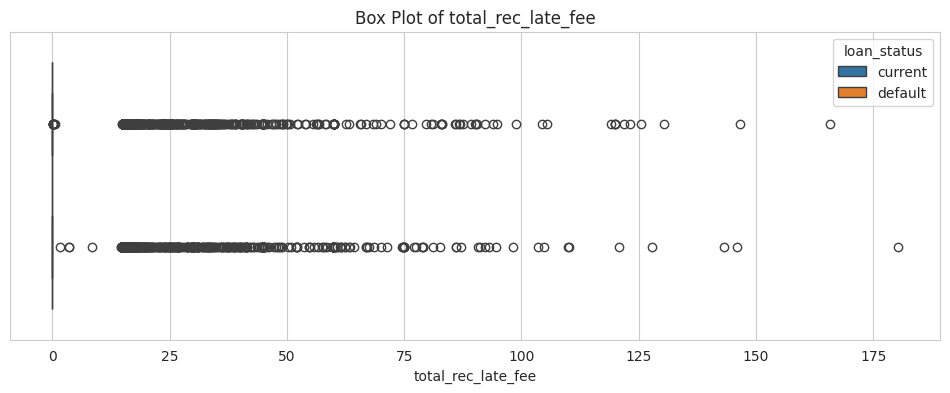

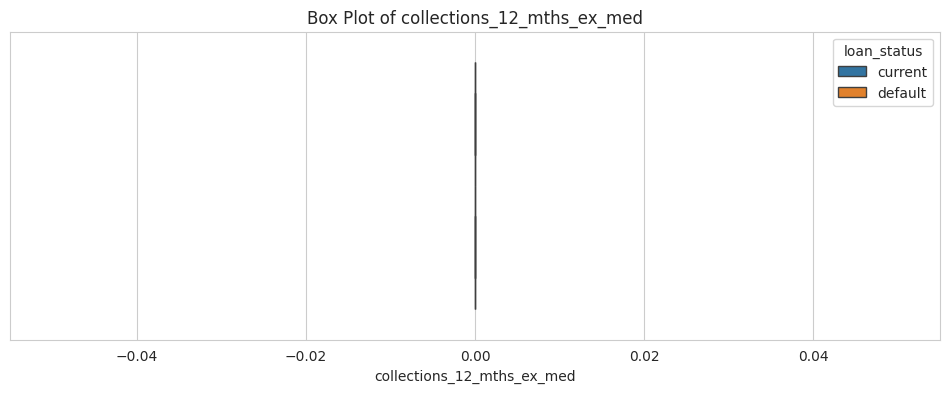

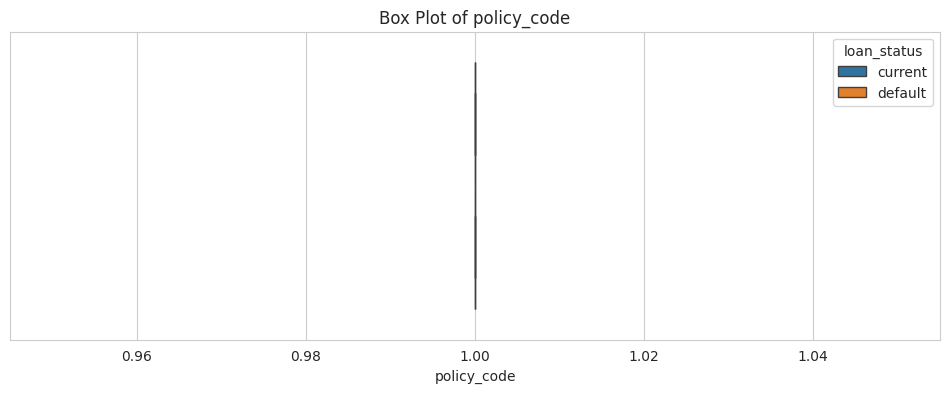

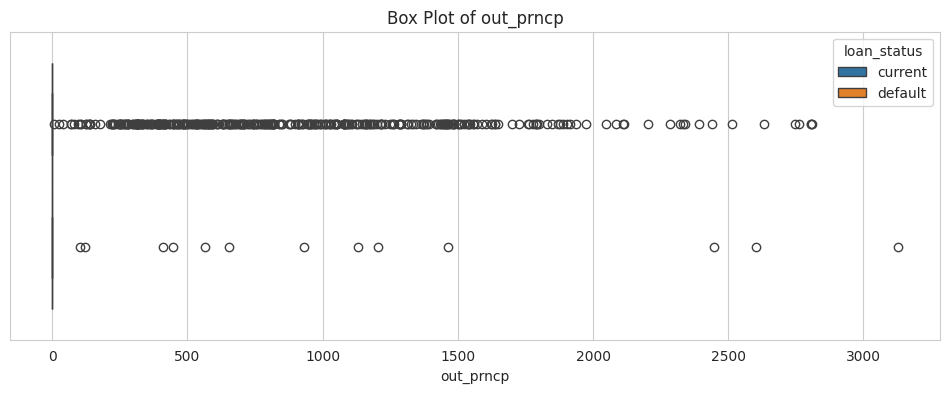

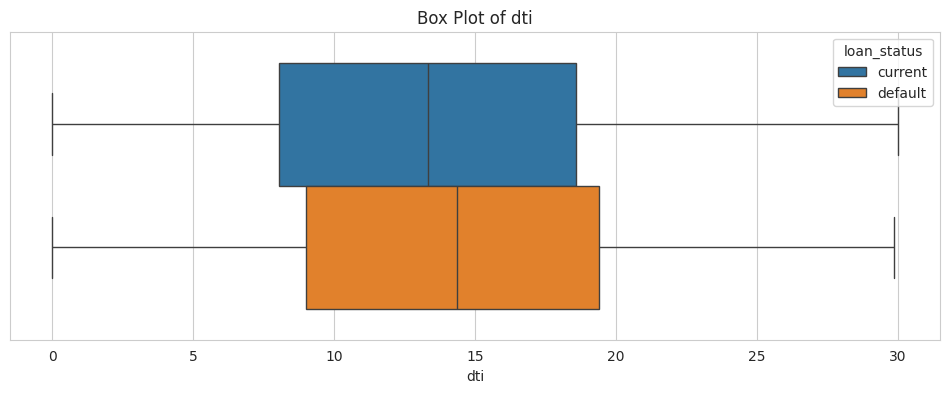

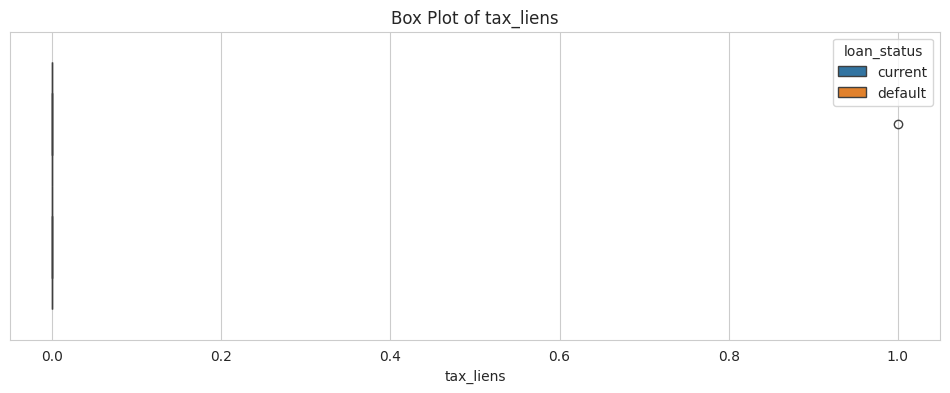

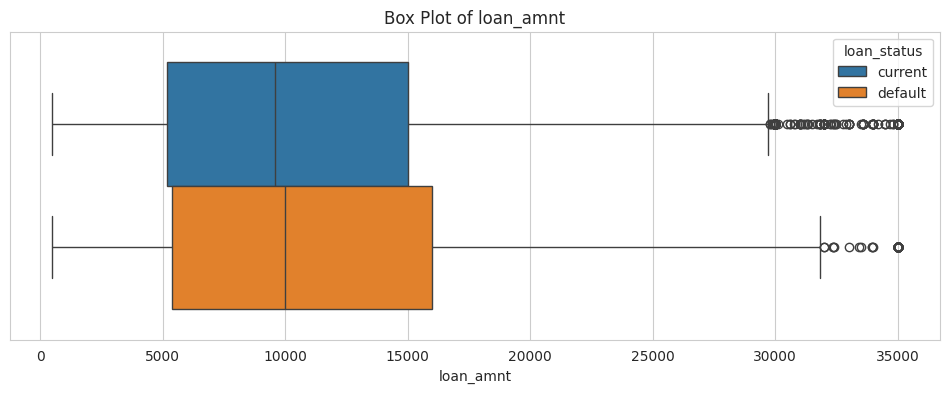

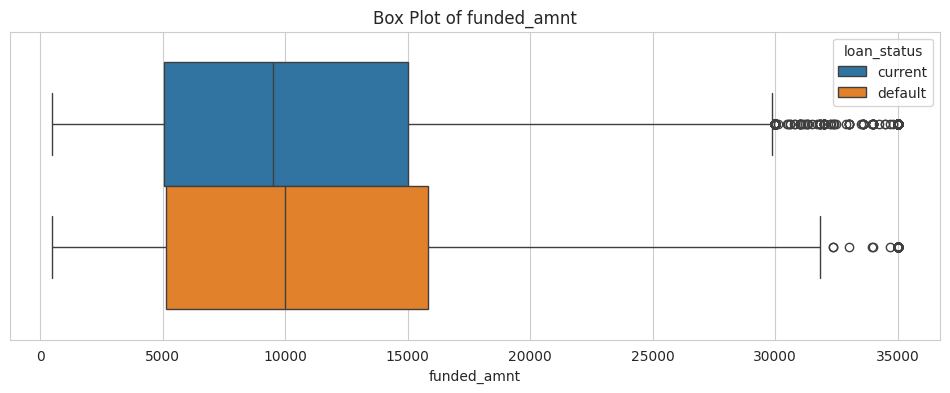

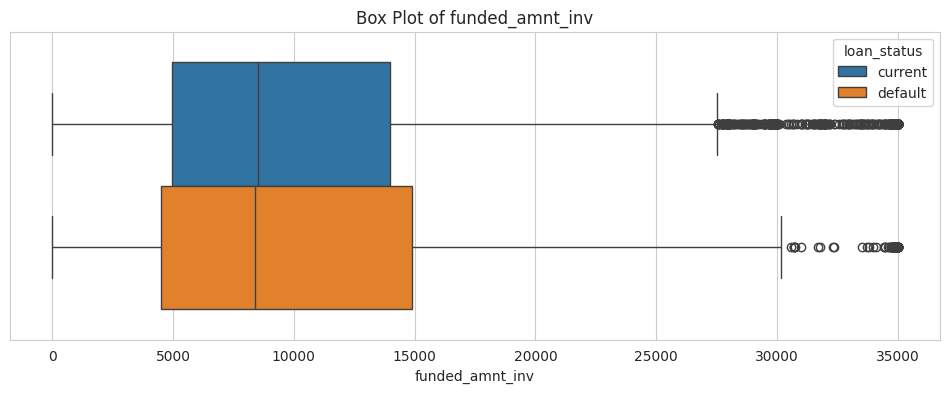

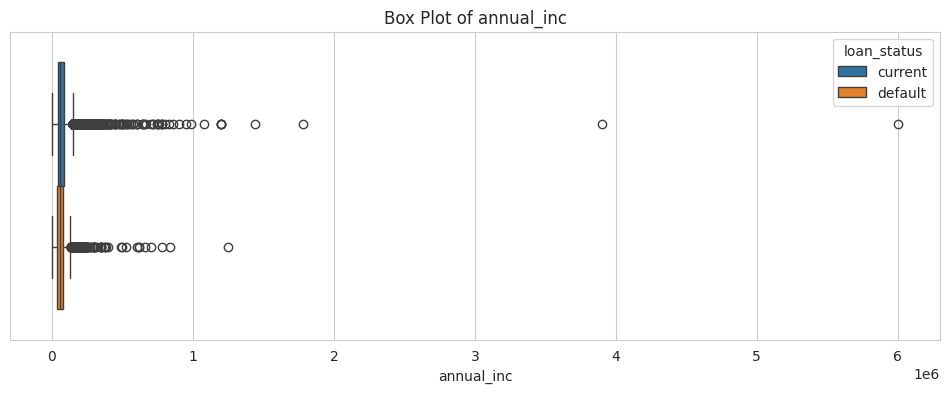

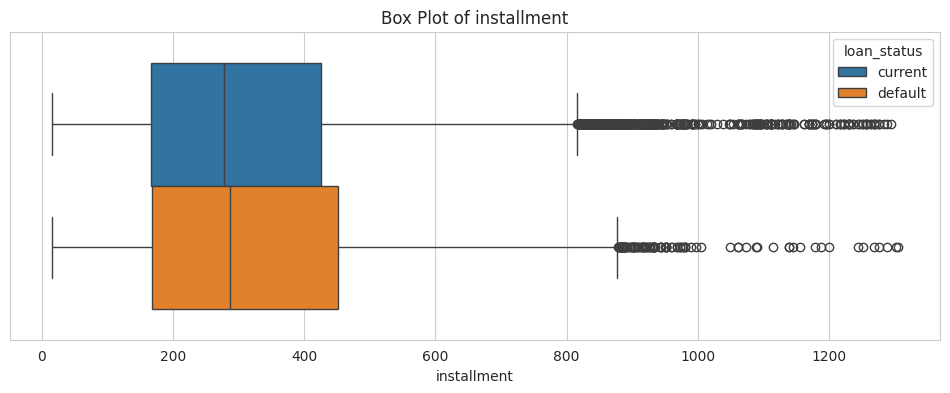

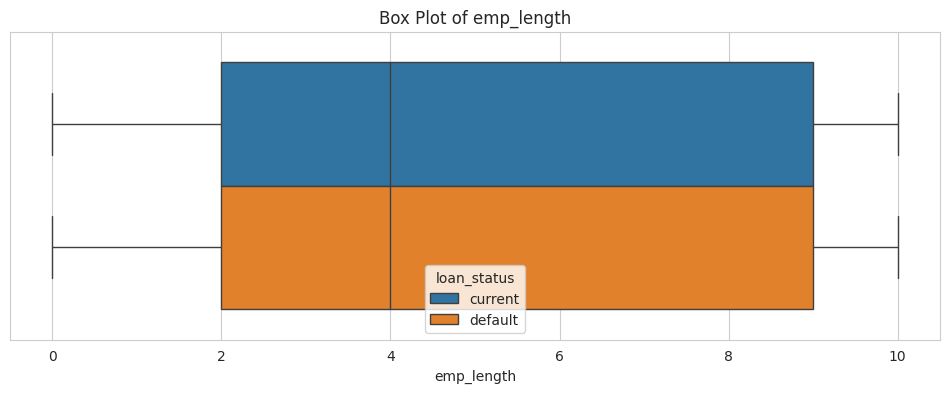

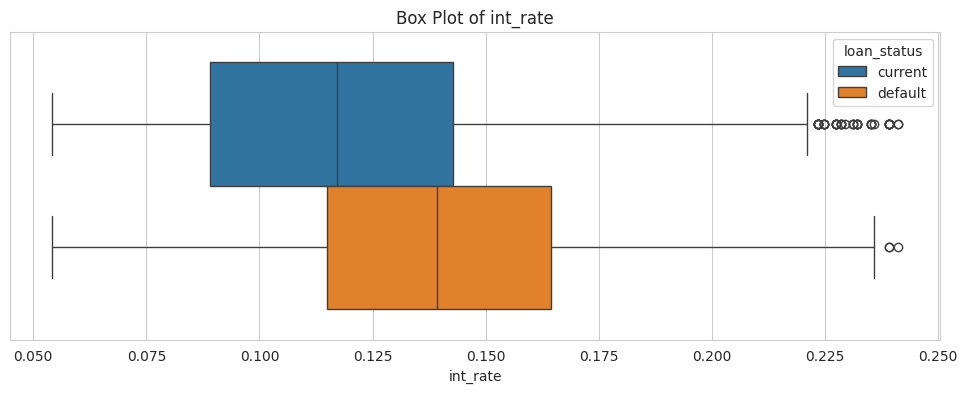

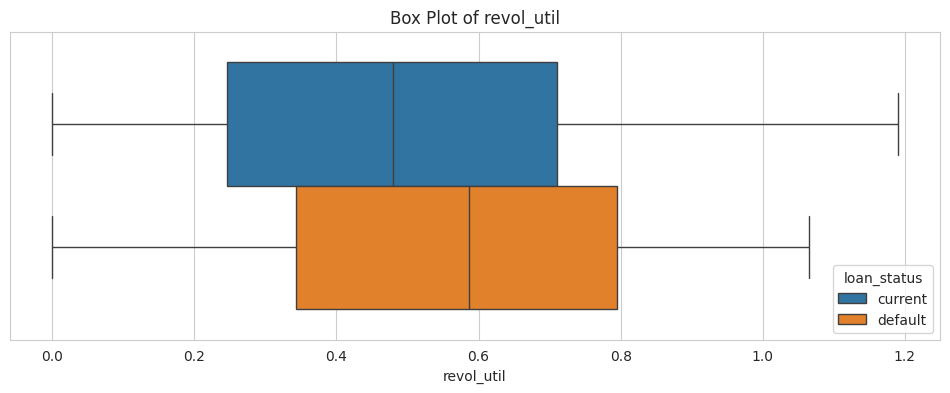

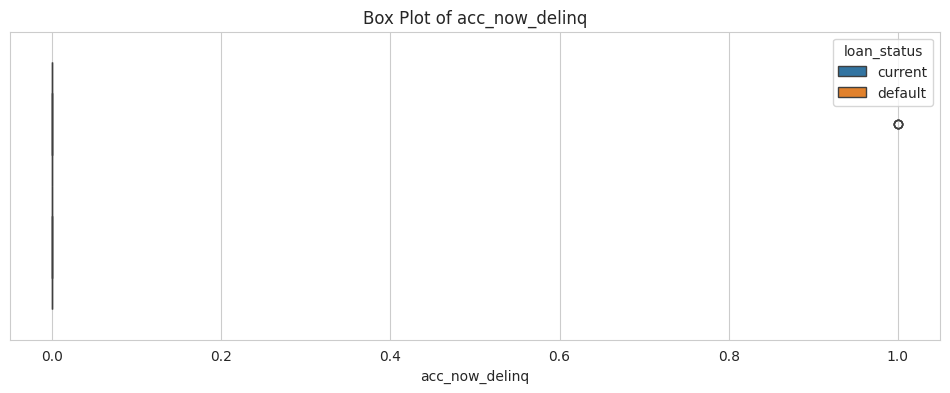

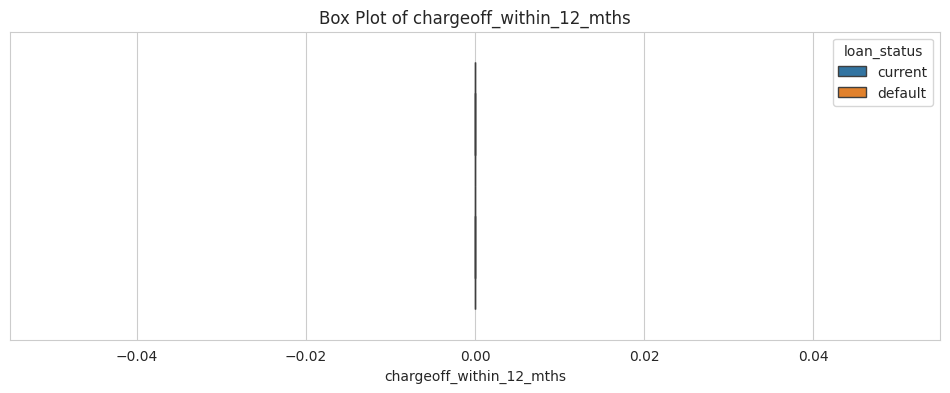

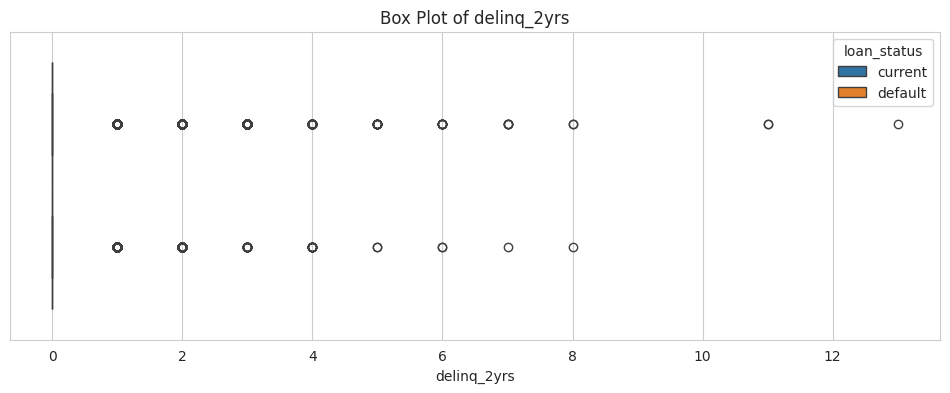

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(12, 4))
    sns.boxplot(data = training_df, x=col, hue="loan_status")
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

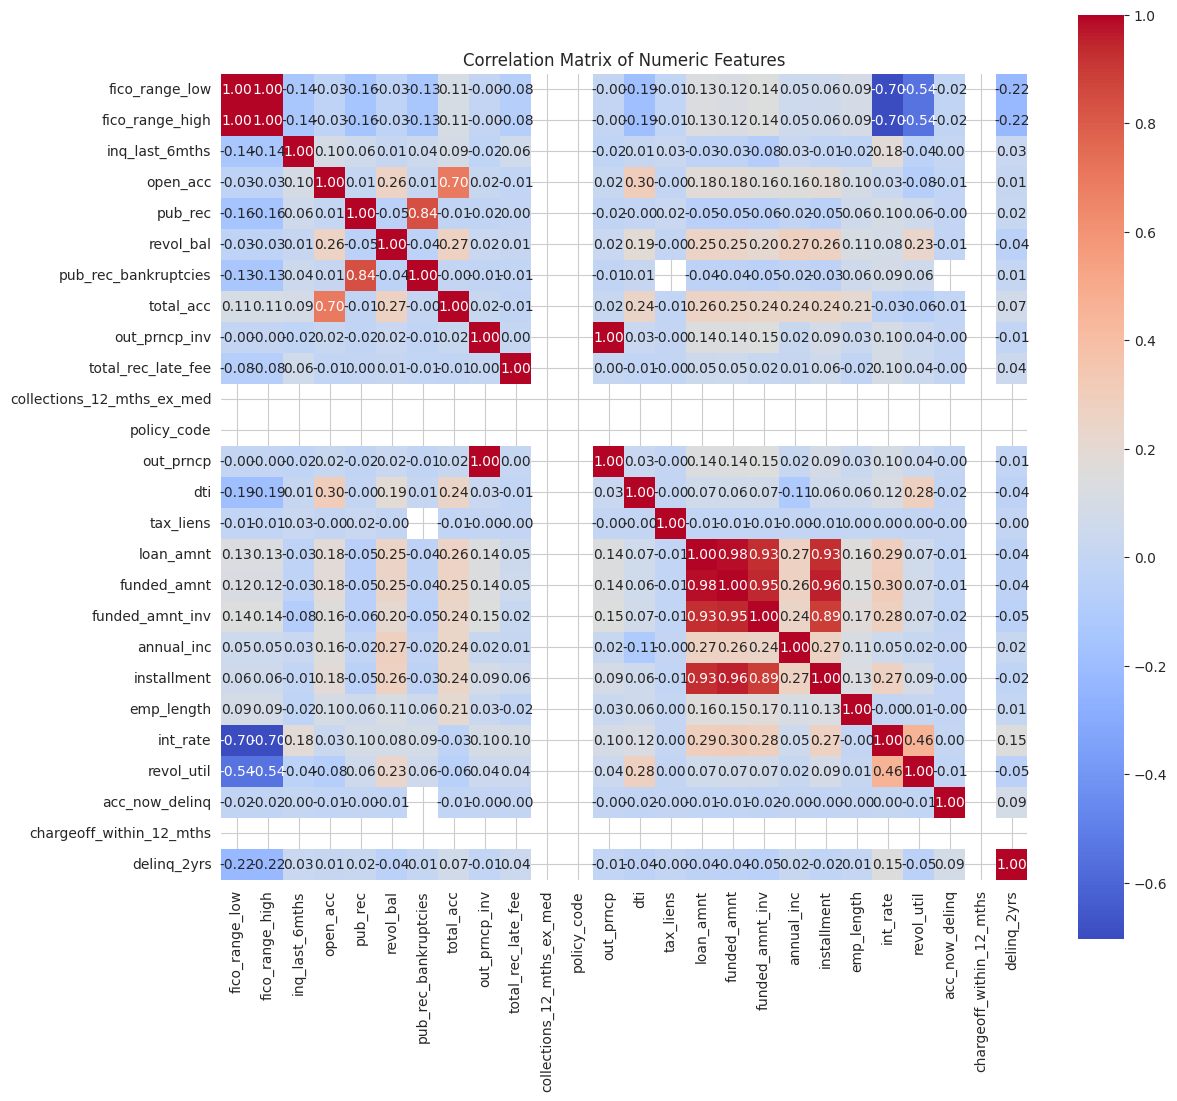

In [ ]:
# Compute the correlation matrix
corr = training_df[numerical_cols].corr()

# Generate a heatmap
plt.figure(figsize=(13, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

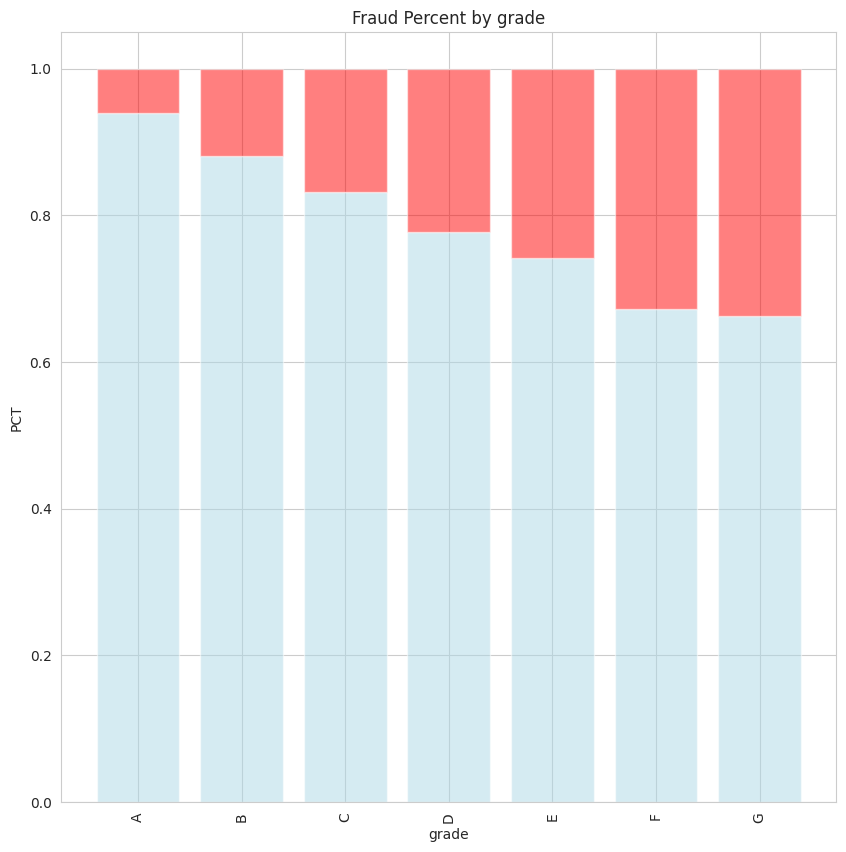

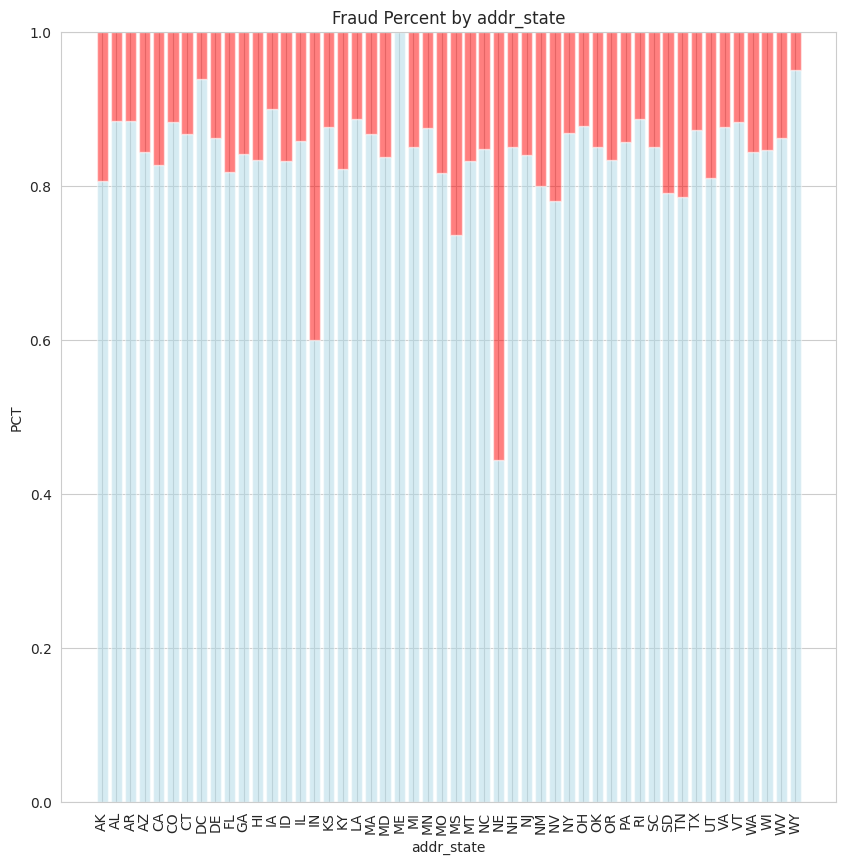

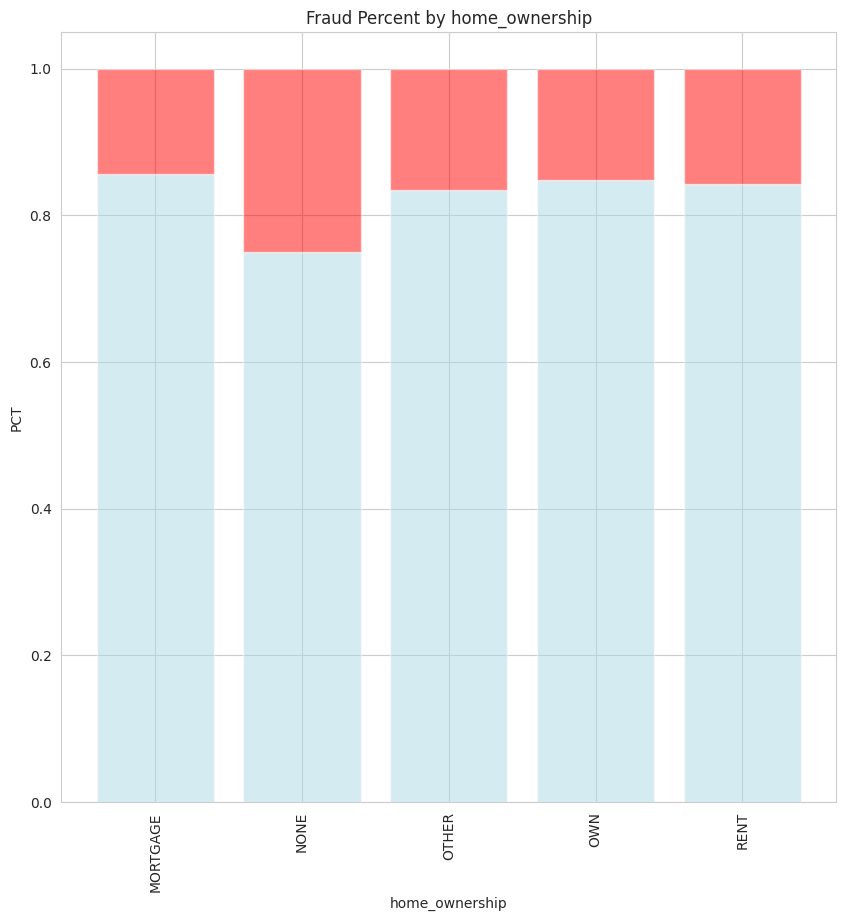

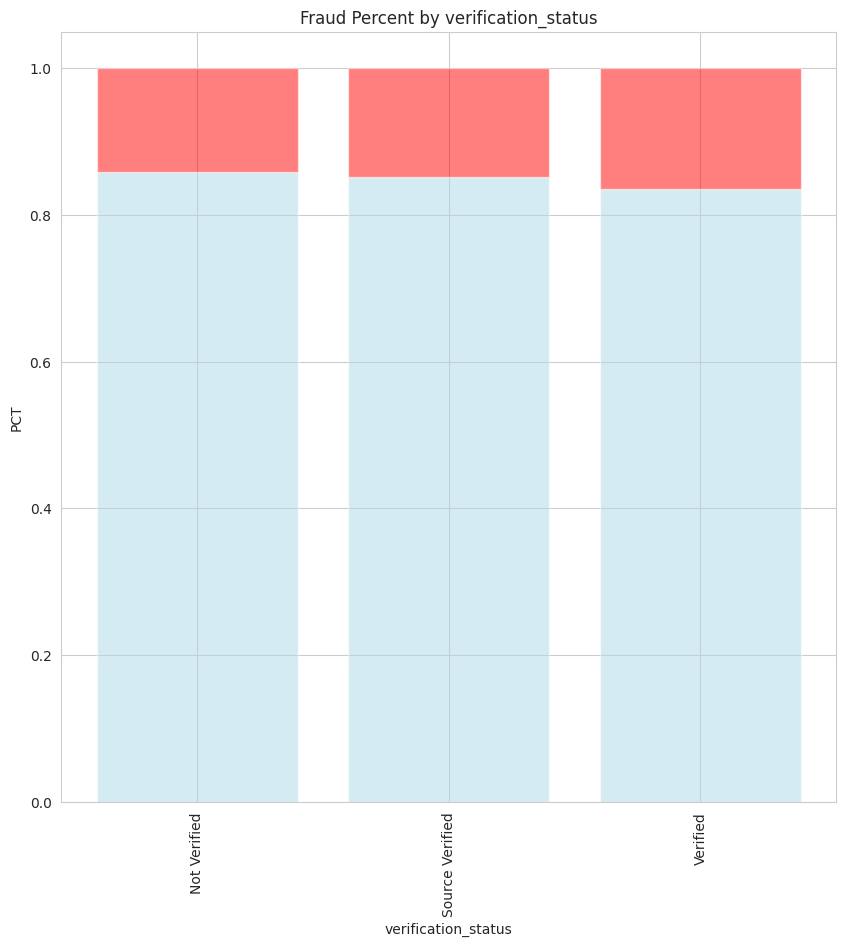

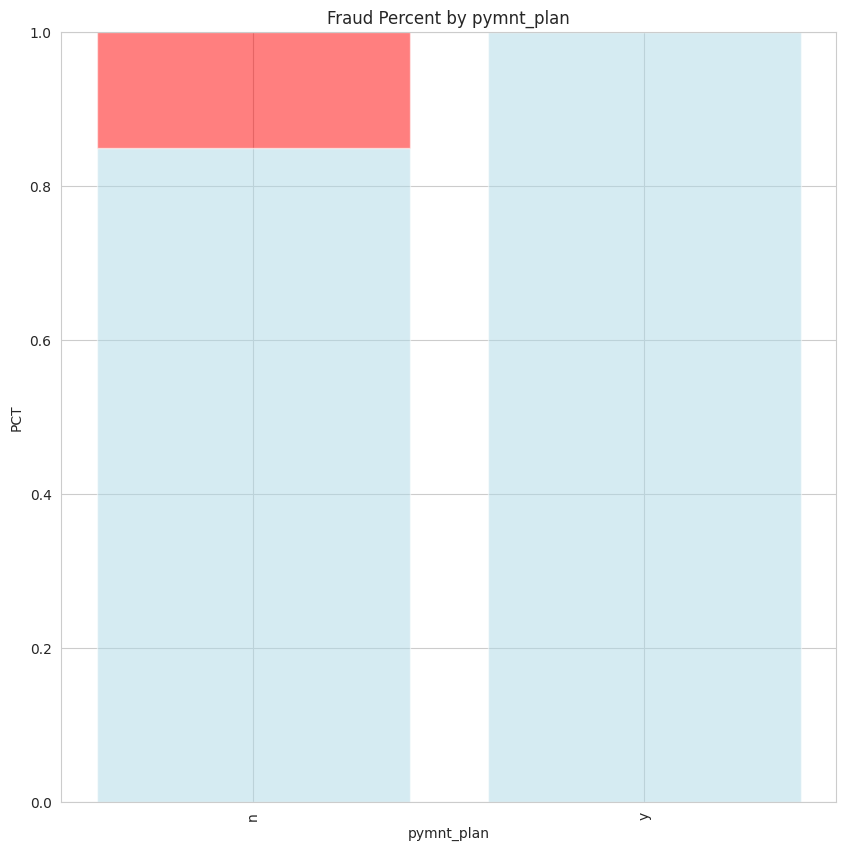

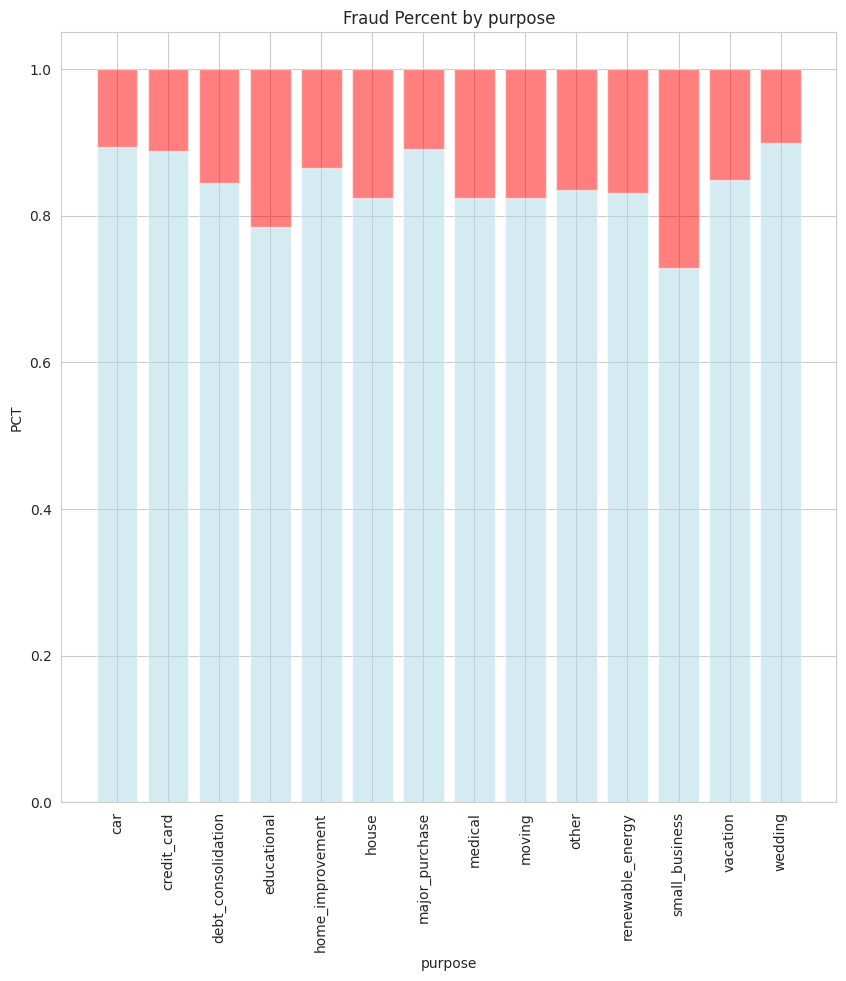

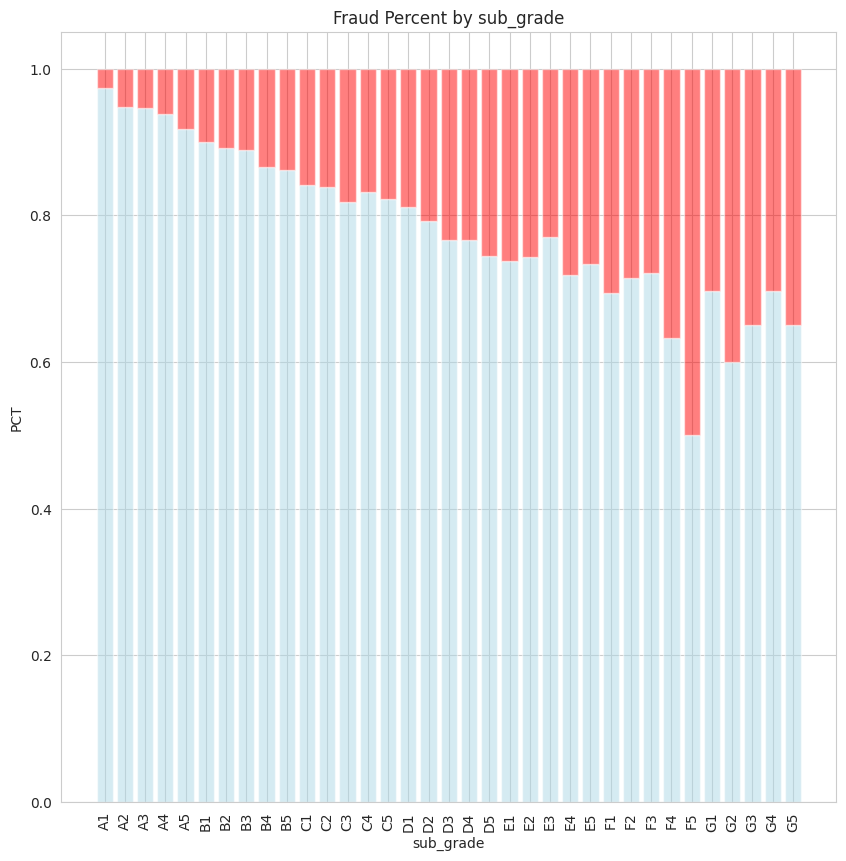

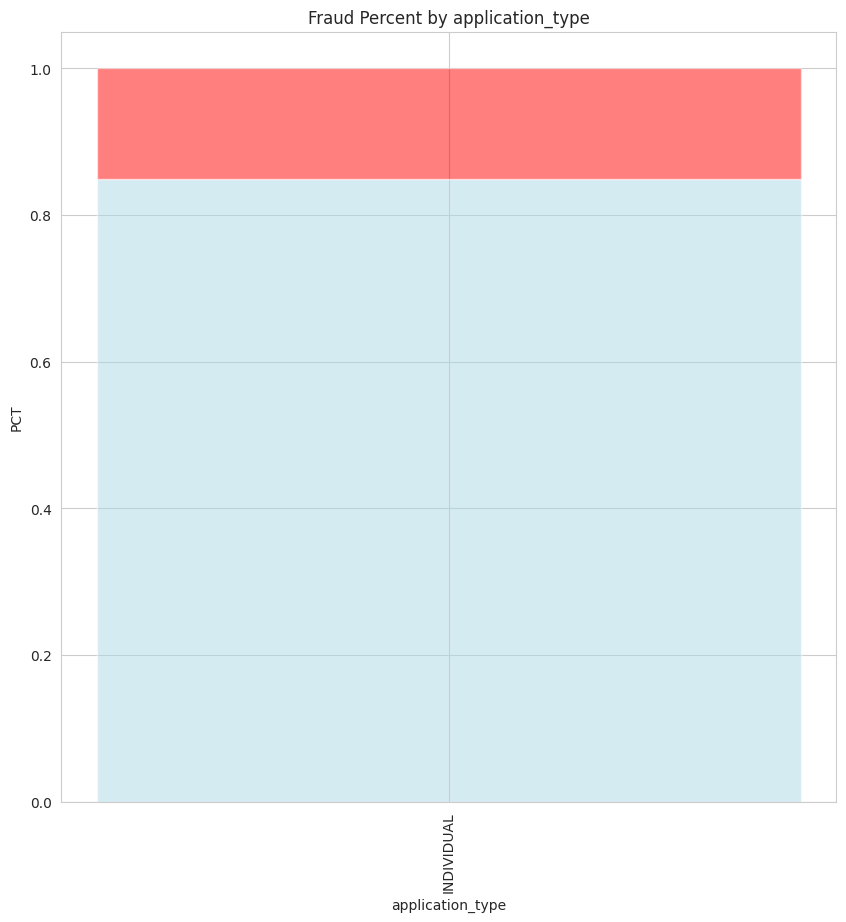

In [ ]:
categorical_columns = ["grade", "addr_state", "home_ownership", "verification_status", "pymnt_plan", "purpose",
                     "sub_grade", "application_type"]

for col in categorical_columns:
    ctab = pd.crosstab(training_df[col], training_df['loan_status'], normalize="index").reset_index()
    plt.figure(figsize=(10,10))
    plt.bar(ctab[col].astype('str'), ctab['current'], facecolor='lightblue', alpha=0.5)
    plt.bar(ctab[col].astype('str'), ctab['default'], bottom=ctab['current'], facecolor='red', alpha=0.5)
    plt.title(f'Fraud Percent by {col}')
    plt.ylabel('PCT')
    plt.xlabel(f'{col}')
    plt.xticks(rotation=90)
    plt.show()

## We can clearly see from the EDA that our numerical and categorical columns of choice appear to be significnant. Let's now build a model!

# We use logistic regression as a baseline

In [ ]:
# Define the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=223, max_iter=500))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
lr_predictions = lr_pipeline.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f" Precision: {precision_score(y_test, lr_predictions):.4f}")
print(f" Recall: {recall_score(y_test, lr_predictions):.4f}")
print(f" AUC: {roc_auc_score(y_test, lr_predictions):.4f}")
print(f" F1 Score: {f1_score(y_test, lr_predictions):.4f}")

Logistic Regression Accuracy: 0.8554
 Precision: 0.5034
 Recall: 0.0580
 AUC: 0.5242
 F1 Score: 0.1040


In [ ]:
y_scores = lr_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Add Precision Column
precisions = []

for threshold in interp_thresholds:
  y_pred = (y_scores >= threshold).astype(int)
  precision = precision_score(y_test, y_pred)
  precisions.append(precision)

target_fpr_df['Precision'] = precisions

target_fpr_df

# Display the DataFrame
target_fpr_df

,Target FPR (%),Expected TPR,Threshold,Precision
0,1.0,0.060325,0.496706,0.506494
1,2.0,0.116783,0.408108,0.496711
2,3.0,0.146945,0.373845,0.454545
3,4.0,0.178654,0.345042,0.431776
4,5.0,0.201083,0.324857,0.404984
5,6.0,0.225831,0.307829,0.389853
6,7.0,0.260634,0.291872,0.386912
7,8.0,0.286156,0.281125,0.376782
8,9.0,0.306265,0.271281,0.365651
9,10.0,0.331013,0.260861,0.359060


In [ ]:
feature_names = preprocessor.get_feature_names_out()
feature_importance = lr_pipeline.named_steps['classifier'].coef_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance[0]})
feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importance_df.head(n=10)

,feature,importance
0,num__fico_range_low,-0.048160
1,num__fico_range_high,-0.048160
2,num__inq_last_6mths,0.171034
3,num__open_acc,-0.008000
4,num__pub_rec,0.030251
5,num__revol_bal,0.093041
6,num__pub_rec_bankruptcies,0.040634
7,num__total_acc,0.008061
8,num__out_prncp_inv,-0.086015
9,num__total_rec_late_fee,0.278046


In [ ]:
# Logistic Regression coefficients as feature importance
lr_coefficients = lr_pipeline.named_steps['classifier'].coef_[0]

# Aligning feature names and coefficients
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Coefficient', ascending=False)
lr_feature_importance_df.head(10)

,Feature,Coefficient
16,num__funded_amnt,1.295638
61,cat__addr_state_NE,1.185758
21,num__int_rate,0.726178
73,cat__addr_state_SD,0.637326
65,cat__addr_state_NV,0.550246
104,cat__purpose_small_business,0.546373
136,cat__sub_grade_F5,0.514713
26,cat__grade_A,0.456477
46,cat__addr_state_ID,0.376883
48,cat__addr_state_IN,0.341284


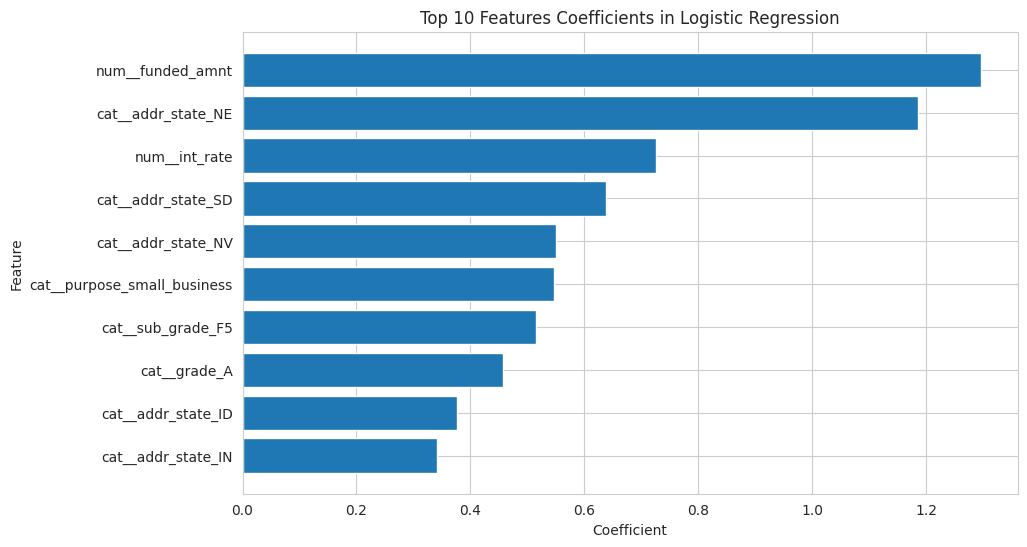

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Top 10 Features Coefficients in Logistic Regression')
plt.barh(lr_feature_importance_df['Feature'][:10], lr_feature_importance_df['Coefficient'][:10])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

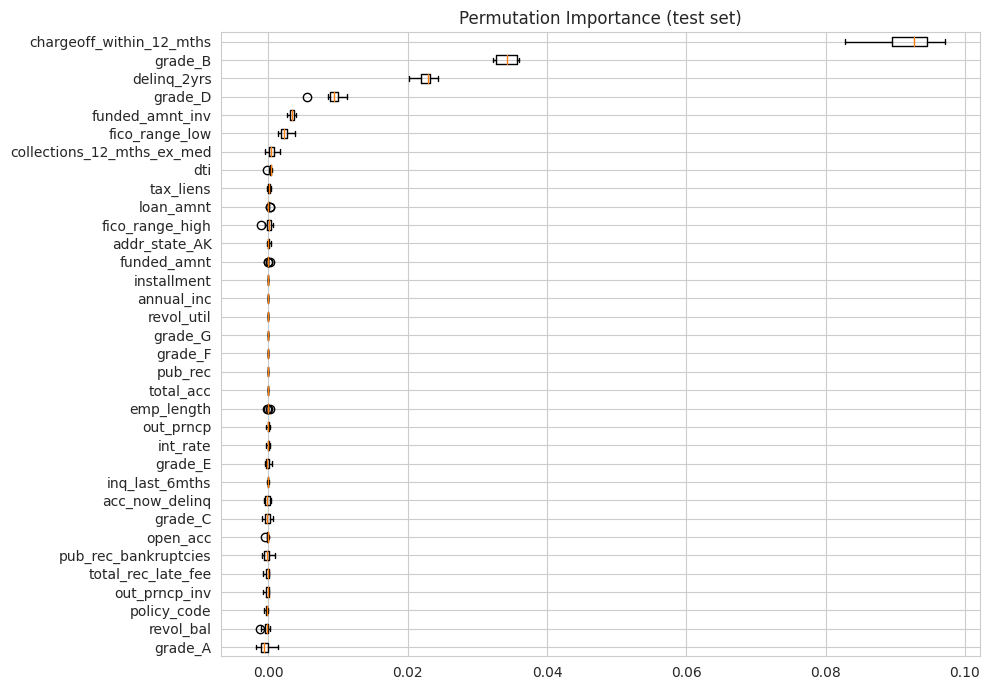

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(lr_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)

# Function to get feature names from column transformer
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    output_features = []

    # Loop through each transformer in the column transformer
    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(pipe, 'get_feature_names_out'):
            # If the transformer has a get_feature_names_out method, use it
            if hasattr(pipe, 'categories_'):
                feature_names = pipe.get_feature_names_out(features)
            else:
                feature_names = pipe.get_feature_names_out()
        else:
            # Otherwise, use the provided feature names
            feature_names = features
        output_features.extend(feature_names)
    return output_features

# Extract feature names from the preprocessor
feature_names = get_feature_names(preprocessor)

# Now using feature_names with sorted_idx for labeling in the plot
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Test Data')

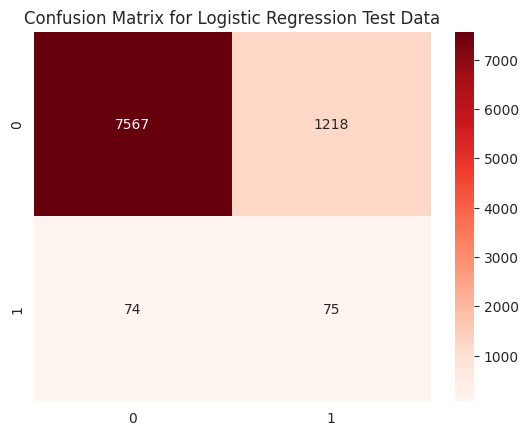

In [ ]:
conf_matrix = confusion_matrix(lr_predictions, y_test)
sns.heatmap(conf_matrix, fmt='.5g', annot=True, cmap = "Reds")
plt.title("Confusion Matrix for Logistic Regression Test Data")

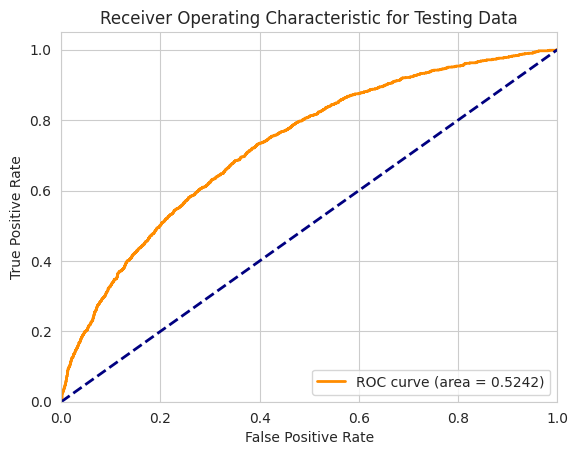

In [ ]:
roc_auc = roc_auc_score(y_test, lr_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

# Next, let's train a random forest!

In [ ]:
# Define the Random Forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=50, n_jobs = -1, random_state=223))])
# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
rf_predictions = rf_pipeline.predict(X_test)
rf_predictions_proba = rf_pipeline.predict_proba(X_test)[:,1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")

Random Forest Accuracy: 0.8642


In [ ]:
y_scores = rf_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Add Precision Column
precisions = []

for threshold in interp_thresholds:
  y_pred = (y_scores >= threshold).astype(int)
  precision = precision_score(y_test, y_pred)
  precisions.append(precision)

target_fpr_df['Precision'] = precisions

target_fpr_df

# Display the DataFrame
target_fpr_df

,Target FPR (%),Expected TPR,Threshold,Precision
0,1.0,0.104915,0.469272,0.666667
1,2.0,0.143351,0.419067,0.549254
2,3.0,0.178103,0.386702,0.528536
3,4.0,0.201606,0.366015,0.489754
4,5.0,0.225217,0.350361,0.450000
5,6.0,0.249331,0.336646,0.417553
6,7.0,0.273551,0.324120,0.417553
7,8.0,0.292108,0.313630,0.393939
8,9.0,0.307891,0.304138,0.393939
9,10.0,0.323847,0.295487,0.360816


In [ ]:
# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Print the metrics
print("Random Forest Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")

Random Forest Model Evaluation:
  Accuracy: 0.8642
  AUC: 0.7087
  Precision: 0.8077
  Recall: 0.0812


In [ ]:
# Create the parameter grid
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [50],
    'classifier__min_samples_leaf': [1]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters:
  classifier__max_depth: None
  classifier__min_samples_leaf: 1
  classifier__min_samples_split: 50
  classifier__n_estimators: 200


In [ ]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,27.818302,0.873350,0.875261,0.025398,None,1,50,200,"{'classifier__max_depth': None, 'classifier__m...",0.729988,0.714555,0.718957,0.721167,0.006491,1
1,4.673728,0.841787,0.442522,0.009166,5,1,50,200,"{'classifier__max_depth': 5, 'classifier__min_...",0.710278,0.697769,0.704457,0.704168,0.005111,3
2,8.708507,0.634072,0.435428,0.191268,10,1,50,200,"{'classifier__max_depth': 10, 'classifier__min...",0.720754,0.710872,0.712697,0.714774,0.004294,2


<Axes: xlabel='param_classifier__n_estimators', ylabel='mean_test_score'>

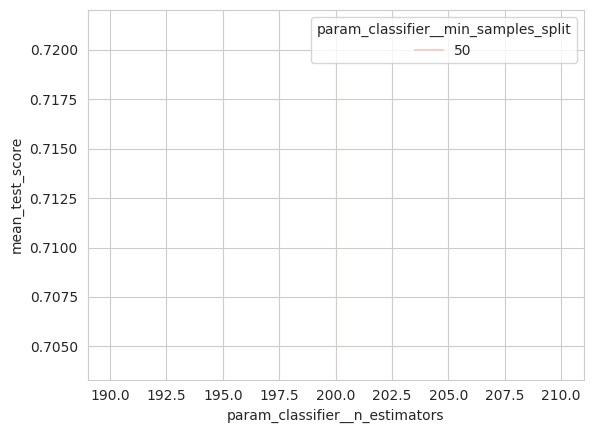

In [ ]:
sns.lineplot(data=cv_results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__min_samples_split')

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=200,
                                                                    min_samples_split=50,
                                                                    n_jobs=-1,
                                                                    random_state=42))])
# Train the pipeline
rf_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'revol_bal',
                                                   'pub_rec_bankruptcies',
                                                   'total_acc', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'collections_12_mths_ex_med',
                                                   'policy_code', 'out...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'addr_state',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'sub_grade',
                                                   'application_type'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=50, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# compare rf_pipeline to rf_pipeline_hpo performance
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf_hpo = rf_pipeline_hpo.predict(X_test)
y_pred_proba_rf_hpo = rf_pipeline_hpo.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Random Forest Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_rf):.4f}")

print("\n -------- \n")
print("Random Forest Model Evaluation with HPO:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_rf_hpo):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_rf_hpo):.4f}")

Random Forest Model Evaluation:
  Accuracy: 0.8642
  AUC: 0.7087
  Precision: 0.8077
  Recall: 0.0812
  F1 Score: 0.1476

 -------- 

Random Forest Model Evaluation with HPO:
  Accuracy: 0.8566
  AUC: 0.7341
  Precision: 1.0000
  Recall: 0.0093
  F1 Score: 0.0184


Text(0.5, 1.0, 'Confusion Matrix for Tuned Random Forest Test Data')

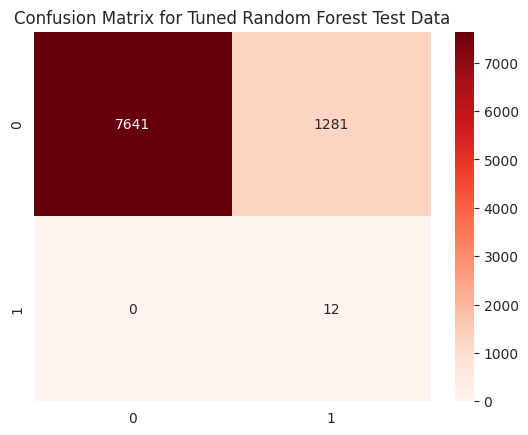

In [ ]:
conf_matrix = confusion_matrix(y_pred_rf_hpo, y_test)
sns.heatmap(conf_matrix, fmt='.5g', annot=True, cmap = "Reds")
plt.title("Confusion Matrix for Tuned Random Forest Test Data")

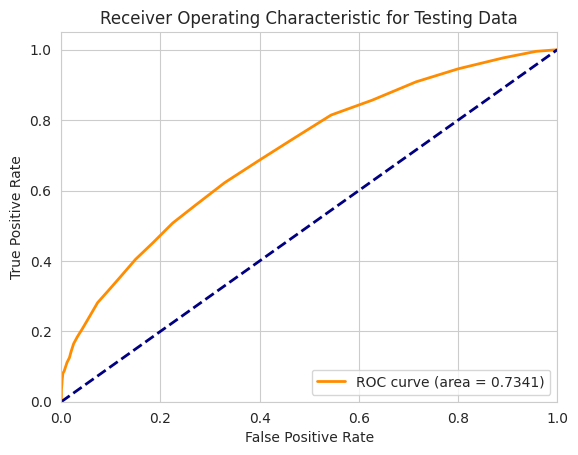

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba_rf_hpo)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_scores = rf_pipeline_hpo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Add Precision Column
precisions = []

for threshold in interp_thresholds:
  y_pred = (y_scores >= threshold).astype(int)
  precision = precision_score(y_test, y_pred)
  precisions.append(precision)

target_fpr_df['Precision'] = precisions

target_fpr_df

# Display the DataFrame
target_fpr_df

,Target FPR (%),Expected TPR,Threshold,Precision
0,1.0,0.117556,0.380142,0.666667
1,2.0,0.164733,0.353009,0.580381
2,3.0,0.197216,0.333260,0.526860
3,4.0,0.218097,0.319879,0.480409
4,5.0,0.245166,0.306577,0.453505
5,6.0,0.267595,0.295865,0.430348
6,7.0,0.283836,0.288347,0.408231
7,8.0,0.300851,0.280898,0.389780
8,9.0,0.322506,0.273956,0.377717
9,10.0,0.340294,0.266865,0.365752


In [ ]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

rf_importances = rf_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
rf_feature_importance_df.head(10)

,Feature,Importance
9,total_rec_late_fee,0.096318
21,int_rate,0.076075
18,annual_inc,0.056218
22,revol_util,0.044846
17,funded_amnt_inv,0.044465
13,dti,0.043514
5,revol_bal,0.042319
19,installment,0.040788
7,total_acc,0.033216
0,fico_range_low,0.031772


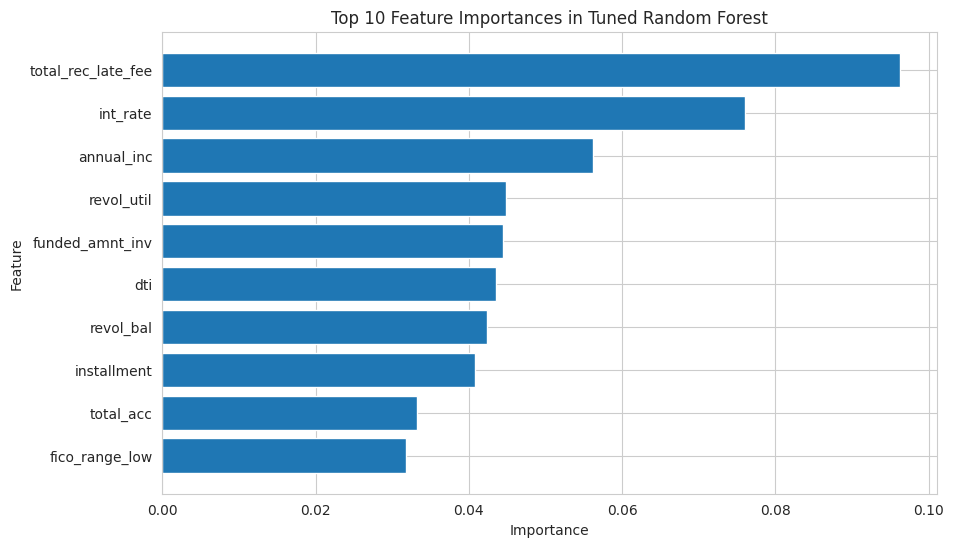

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances in Tuned Random Forest')
plt.barh(rf_feature_importance_df['Feature'][:10], rf_feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Initiate a GBM

In [ ]:
# Initialize the pipeline with the preprocessor and a Gradient Boosting classifier
gbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(
                                                                        learning_rate=0.1, n_estimators=100,
                                                                    ))])
# Train the pipeline
gbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'revol_bal',
                                                   'pub_rec_bankruptcies',
                                                   'total_acc', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'collections_12_mths_ex_med',
                                                   'policy_code', 'out...
                                                   'acc_now_delinq',
                                                   'chargeoff_within_12_mths',
                                                   'delinq_2yrs']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'addr_state',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'sub_grade',
                                                   'application_type'])])),
                ('classifier', GradientBoostingClassifier())])

In [ ]:
# Predictions
y_pred_gbm = gbm_pipeline.predict(X_test)
y_pred_proba_gbm = gbm_pipeline.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_gbm)
auc_rf = roc_auc_score(y_test, y_pred_proba_gbm)
precision_rf = precision_score(y_test, y_pred_gbm)
recall_rf = recall_score(y_test, y_pred_gbm)

# Print the metrics
print("GB Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")

GB Model Evaluation:
  Accuracy: 0.8660
  AUC: 0.7453
  Precision: 0.7353
  Recall: 0.1160


In [ ]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(gbm_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters:
  classifier__learning_rate: 0.1
  classifier__n_estimators: 200


In [ ]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.959868,0.786174,0.089585,0.006566,0.05,100,"{'classifier__learning_rate': 0.05, 'classifie...",0.739317,0.723818,0.730066,0.731067,0.006367,6
1,21.639099,2.191761,0.126858,0.000995,0.05,200,"{'classifier__learning_rate': 0.05, 'classifie...",0.739601,0.730282,0.735714,0.735199,0.003822,3
2,12.842655,0.727598,0.130342,0.041482,0.1,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.740679,0.731481,0.735605,0.735922,0.003762,2
3,24.439059,1.361527,0.114598,0.003036,0.1,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.738770,0.731663,0.739229,0.736554,0.003464,1
4,12.372120,0.314674,0.094485,0.002647,0.2,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.736295,0.730544,0.737534,0.734791,0.003045,4
5,19.725366,2.628317,0.114056,0.004449,0.2,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.737273,0.726561,0.734168,0.732667,0.004500,5


<Axes: xlabel='param_classifier__n_estimators', ylabel='mean_test_score'>

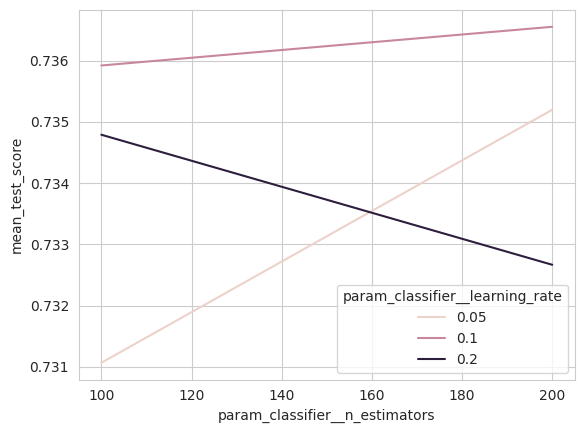

In [ ]:
sns.lineplot(data=cv_results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__learning_rate')

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
gbm_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(n_estimators=200,
                                                                    learning_rate=0.1,
                                                                    ))])
# Train the pipeline
gbm_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'revol_bal',
                                                   'pub_rec_bankruptcies',
                                                   'total_acc', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'collections_12_mths_ex_med',
                                                   'policy_code', 'out...
                                                   'chargeoff_within_12_mths',
                                                   'delinq_2yrs']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'addr_state',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'sub_grade',
                                                   'application_type'])])),
                ('classifier', GradientBoostingClassifier(n_estimators=200))])

In [ ]:
y_pred_gbm  = gbm_pipeline.predict(X_test)
y_pred_proba_gbm = gbm_pipeline.predict_proba(X_test)[:, 1]

y_pred_gbm_hpo  = gbm_pipeline_hpo.predict(X_test)
y_pred_proba_gbm_hpo = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("GBM Baseline:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_gbm):.3f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_gbm):.3f}")


print("\n -------- ")
print("GBM Optimized:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm_hpo):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_gbm_hpo):.3f}")

GBM Baseline:
  Accuracy: 0.866
  AUC: 0.745
  Precision: 0.735
  Recall: 0.116
  F1 Score: 0.200

 -------- 
GBM Optimized:
  Accuracy: 0.866
  AUC: 0.751
  Precision: 0.707
  Recall: 0.131
  F1 Score: 0.221


In [ ]:
y_scores = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Add Precision Column
precisions = []

for threshold in interp_thresholds:
  y_pred = (y_scores >= threshold).astype(int)
  precision = precision_score(y_test, y_pred)
  precisions.append(precision)

target_fpr_df['Precision'] = precisions

target_fpr_df

,Target FPR (%),Expected TPR,Threshold,Precision
0,1.0,0.135344,0.489144,0.697211
1,2.0,0.186388,0.404338,0.613232
2,3.0,0.221964,0.360528,0.556202
3,4.0,0.242846,0.332050,0.506452
4,5.0,0.273009,0.307679,0.480272
5,6.0,0.296210,0.290562,0.454330
6,7.0,0.320959,0.277084,0.437302
7,8.0,0.345708,0.263474,0.422495
8,9.0,0.369683,0.252078,0.410300
9,10.0,0.389018,0.244242,0.397001


In [ ]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

gbm_importances = gbm_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
gbm_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbm_importances})
gbm_feature_importance_df = gbm_feature_importance_df.sort_values(by='Importance', ascending=False)
gbm_feature_importance_df.head(10)

,Feature,Importance
9,total_rec_late_fee,0.370176
21,int_rate,0.191421
18,annual_inc,0.066170
17,funded_amnt_inv,0.040243
2,inq_last_6mths,0.033518
19,installment,0.028813
22,revol_util,0.028252
15,loan_amnt,0.025643
13,dti,0.023305
5,revol_bal,0.018660


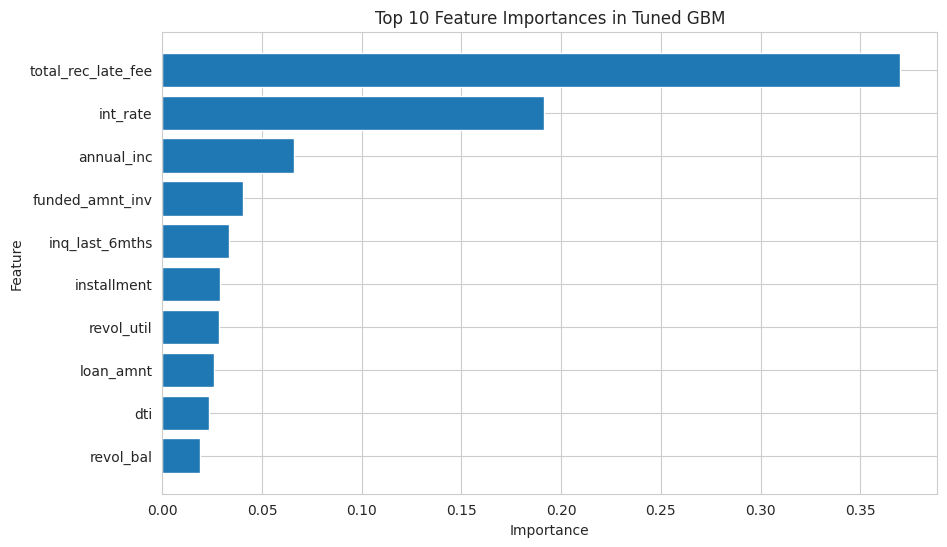

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances in Tuned GBM')
plt.barh(gbm_feature_importance_df['Feature'][:10], gbm_feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix for Tuned GBM Test Data')

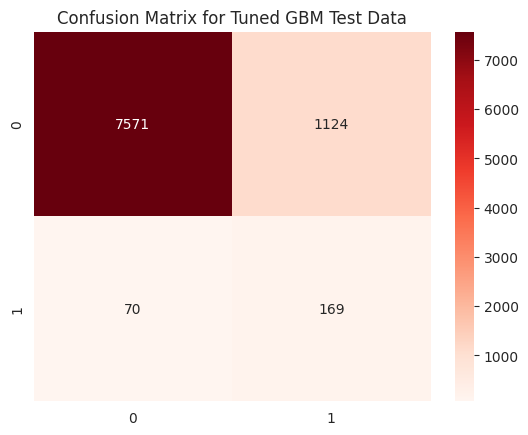

In [ ]:
conf_matrix = confusion_matrix(y_pred_gbm_hpo, y_test)
sns.heatmap(conf_matrix, fmt='.5g', annot=True, cmap = "Reds")
plt.title("Confusion Matrix for Tuned GBM Test Data")

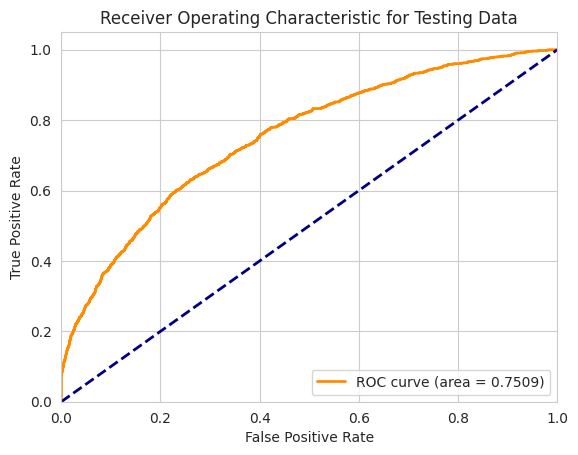

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba_gbm_hpo)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

# AutoGluon

In [ ]:
!pip install autogluon.tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempt

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
# Split the dataset into train and test
train_data, test_data,  = train_test_split(training_df, test_size=0.3, random_state=223)
print(f"X_train: {train_data.shape}")
print(f"X_test: {test_data.shape}")

X_train: (20843, 52)
X_test: (8934, 52)


In [ ]:
time_limit = 120           # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'roc_auc'        # specify your evaluation metric here

# Columns to exclude
ignored_columns = ['loan_status']
train_data.drop(columns=ignored_columns, inplace=True)
test_data.drop(columns=ignored_columns, inplace=True)

# Initialize the TabularPredictor object.
glu_model = TabularPredictor(label='loan_status',
                             problem_type='binary',
                             eval_metric=metric)


# Fit the model.
"""
presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
"""
glu_model = glu_model.fit(train_data,
                          time_limit=time_limit,
                          presets='medium_quality', # switch to one of the above presets.
                          )

KeyError: "['loan_status'] not found in axis"

In [ ]:
glu_model.evaluate(test_data)